In [1]:
import cogsworth
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [2]:
import sys
sys.path.append("../src")
import plotting

In [3]:
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Get m11h

In [4]:
import gala.potential as gp
m11h_pot = gp.load("/mnt/home/twagg/supernova-feedback/data/m11h_new_potential.yml")

In [5]:
import pynbody

In [4]:
%%time
m11h = cogsworth.hydro.utils.prepare_snapshot("/mnt/home/chayward/firesims/fire2/public_release/core/m11h_res7100/output/snapshot_600.hdf5")

cogsworth warning: Looks like you're loading a snapshot that doesn't specify its units, I'm going to infer them but make sure the outputted units looks right!
cogsworth warning: I couldn't find a halo catalogue, so I'll use pynbody's built-in halo finder to centre the snapshot


CPU times: user 6.19 s, sys: 1.06 s, total: 7.25 s
Wall time: 11.1 s


In [5]:
mask = (m11h["x"]**2 + m11h["y"]**2 + m11h["z"]**2)**(0.5) < 100

In [6]:
m11h_h1 = m11h[mask]

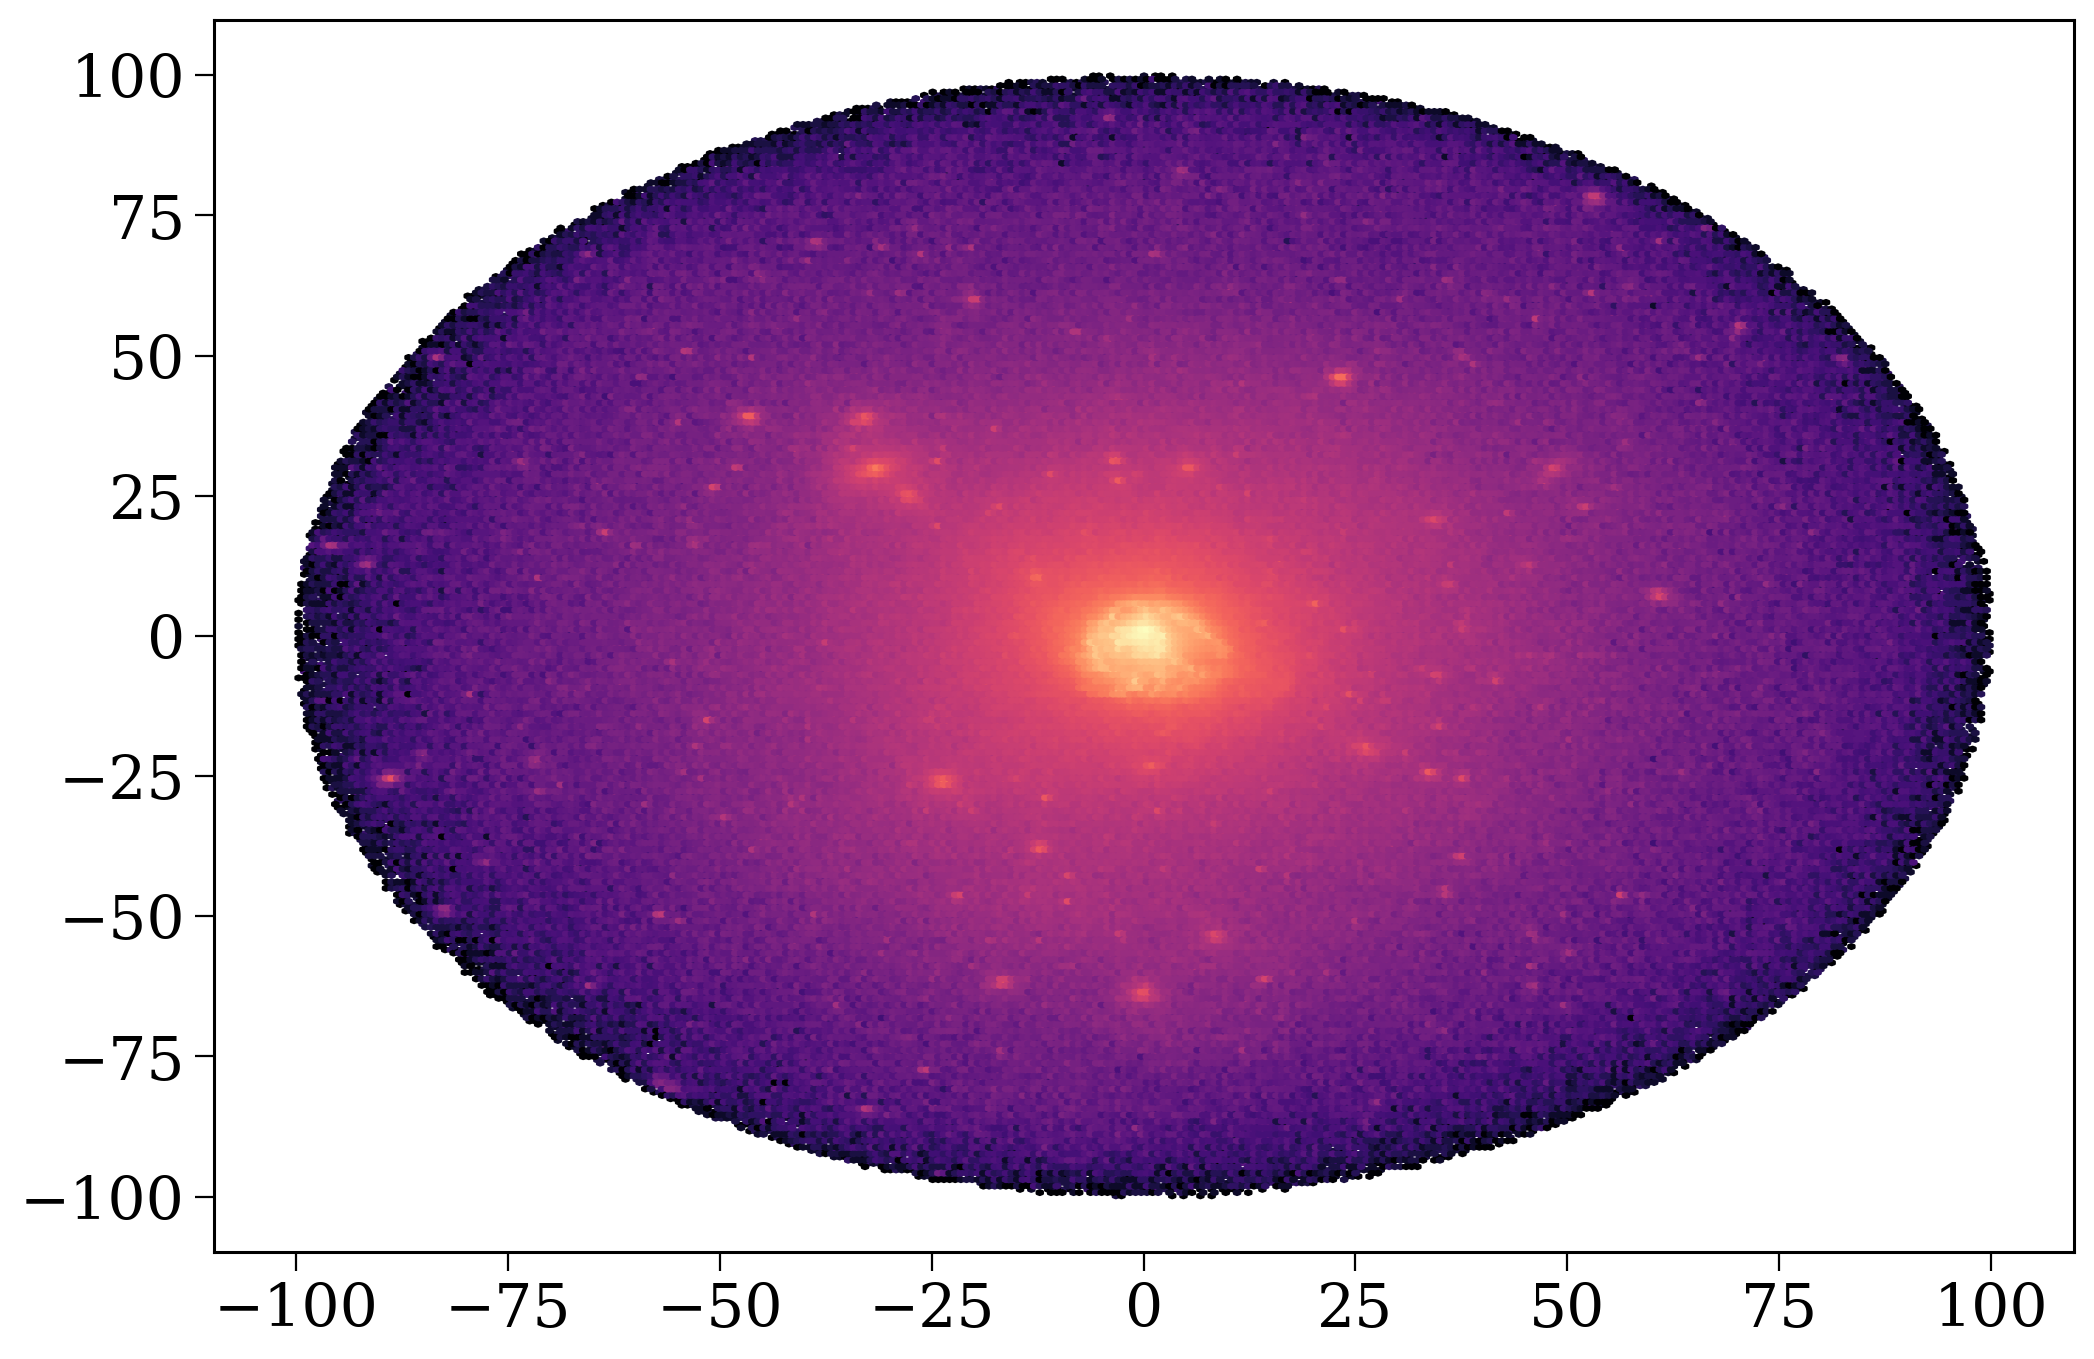

In [7]:
plt.hexbin(m11h_h1["x"], m11h_h1["y"], bins="log", gridsize=300, cmap="magma")

In [8]:
m11h_h1.s["mass"].sum()

SimArray(4.04838775e+09, 'Msol')

In [21]:
t_mask = (13736.52127883025 - m11h_h1.s["tform"].in_units("Myr")) < 150

In [25]:
m11h_h1.s["mass"][t_mask].sum() / 150e6

SimArray(0.48707225, 'Msol')

In [ ]:
m11h_h1.s["tform"].in_units("Myr")[t_mask]

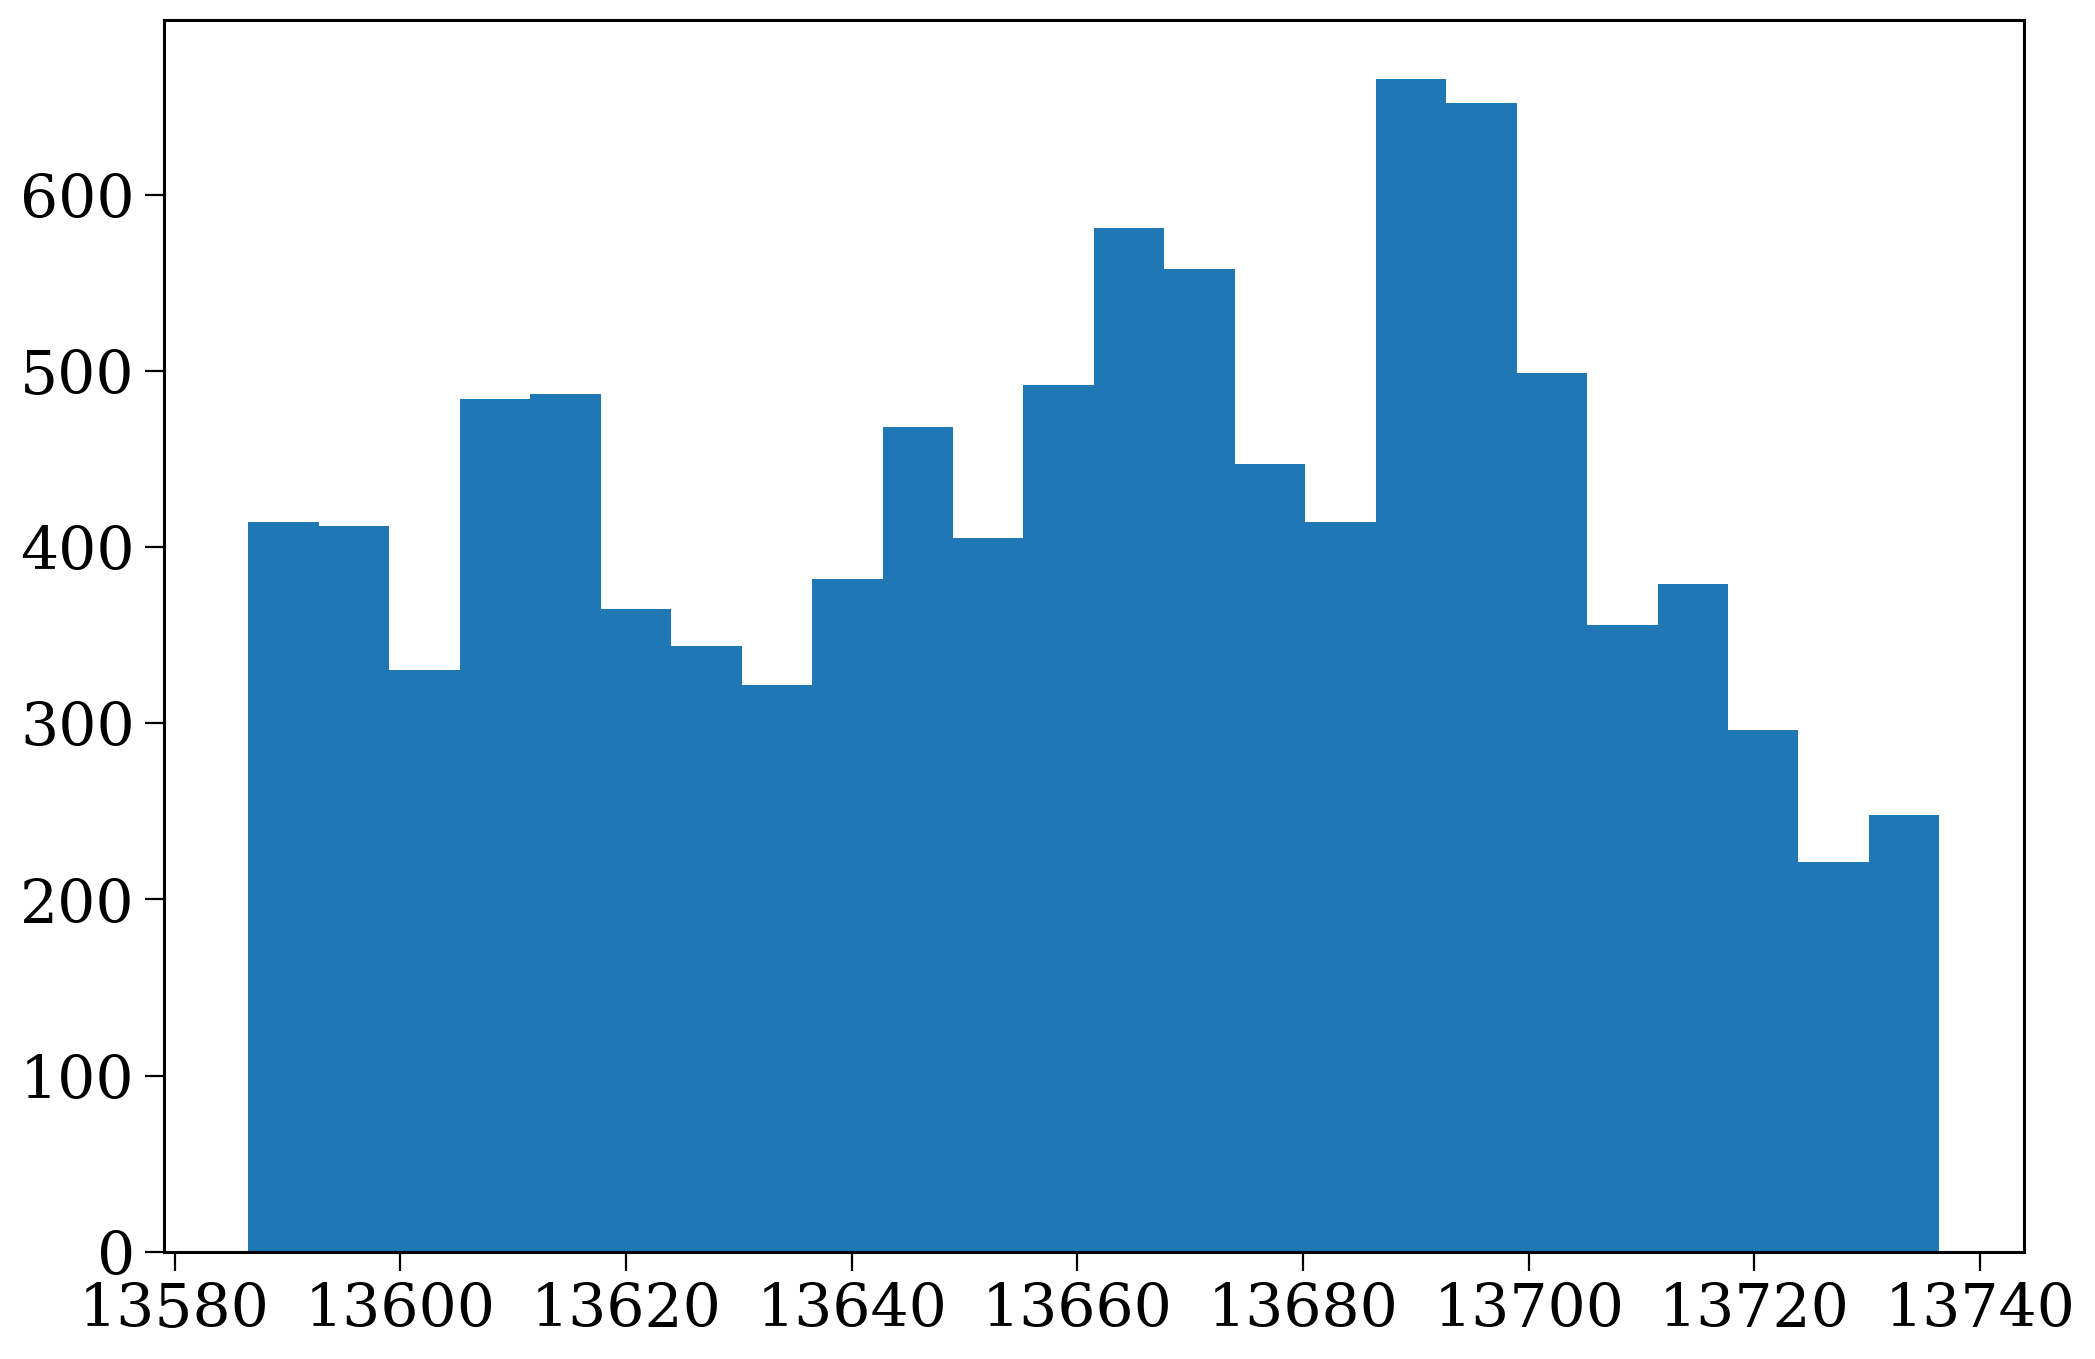

In [22]:
plt.hist(m11h_h1.s["tform"].in_units("Myr")[t_mask], bins="fd");
plt.show()

In [46]:
R_range = np.linspace(0.00001, 25, 1000) * u.kpc
# pot_at_R = m11h_pot(q=[R_range, np.zeros_like(R_range), np.zeros_like(R_range)])
vcirc_at_R = m11h_pot.circular_velocity(q=[R_range, np.zeros_like(R_range), np.zeros_like(R_range)])

In [44]:
R = np.sqrt(m11h_h1["x"]**2 + m11h_h1["y"]**2)

In [49]:
np.argsort(R)

SimArray([2036000, 2036121, 1819969, ..., 1004437,  559141, 1004569], 'kpc')

In [51]:
m11h_h1["mass"][np.argsort(R)].cumsum()

SimArray([5.07705522e+03, 1.12647268e+04, 1.75778200e+04, ...,
          5.60007105e+10, 5.60007494e+10, 5.60007883e+10], 'Msol')

In [45]:
m11h_h1["mass"]

SimArray([9016.02745403, 9411.17113652, 9328.24411179, ..., 5573.92270901,
          5568.63919682, 5242.10593887], 'Msol')

In [17]:
from scipy.interpolate import interp1d

In [26]:
vcirc_at_R_func = interp1d(R_range, vcirc_at_R)

In [54]:
mass_enclosed_at_R_func = interp1d(np.sort(R), m11h_h1["mass"][np.argsort(R)].cumsum())

In [65]:
def compute_circularity(snap, vcirc_at_R_func, mass_enclosed_at_R_func):
    """
    Compute the circularity (ε) of particles in a galaxy simulation.

    Parameters:
    positions : ndarray, shape (N, 3)
        Positions of particles in kpc.
    velocities : ndarray, shape (N, 3)
        Velocities of particles in km/s.
    masses : ndarray, shape (N,)
        Masses of particles in Msun.
    potential_function : function
        A function Φ(R) that returns the gravitational potential at a given radius R.

    Returns:
    circularity : ndarray, shape (N,)
        Circularity values for each particle.
    """
    
    # Compute cylindrical radius R
    R = np.sqrt(snap["x"]**2 + snap["y"]**2)
    
    # Compute specific angular momentum along the z-axis
    J_z = snap["x"] * snap["vy"] - snap["y"] * snap["vx"]  # Specific angular momentum in kpc * km/s

    print(J_z)

    # v_circ = vcirc_at_R_func(R)
    v_circ = np.sqrt(const.G * mass_enclosed_at_R_func(R) * u.Msun / (R * u.kpc)).to(u.km / u.s)
    
    # Compute circular angular momentum J_circ = R * v_circ
    J_circ = R * v_circ
    
    # Avoid division by zero for non-disk particles
    J_circ[J_circ == 0] = np.nan

    print(J_circ)
    
    # Compute circularity
    epsilon = J_z / J_circ
    
    return epsilon.value, R, J_z, v_circ, J_circ

In [12]:
len(m11h)/len(m11h_h1)

12.84915201582275

In [66]:
%%time
eps = compute_circularity(m11h_h1, vcirc_at_R_func, mass_enclosed_at_R_func)[0]

[697.87806038 630.77069413 738.79095676 ... 652.19270566 733.22646786
 744.34066395]
[912.84891591 912.37103054 910.9907158  ... 620.67071329 694.04216168
 673.66689508] km / s
CPU times: user 1.12 s, sys: 4.04 ms, total: 1.12 s
Wall time: 1.12 s


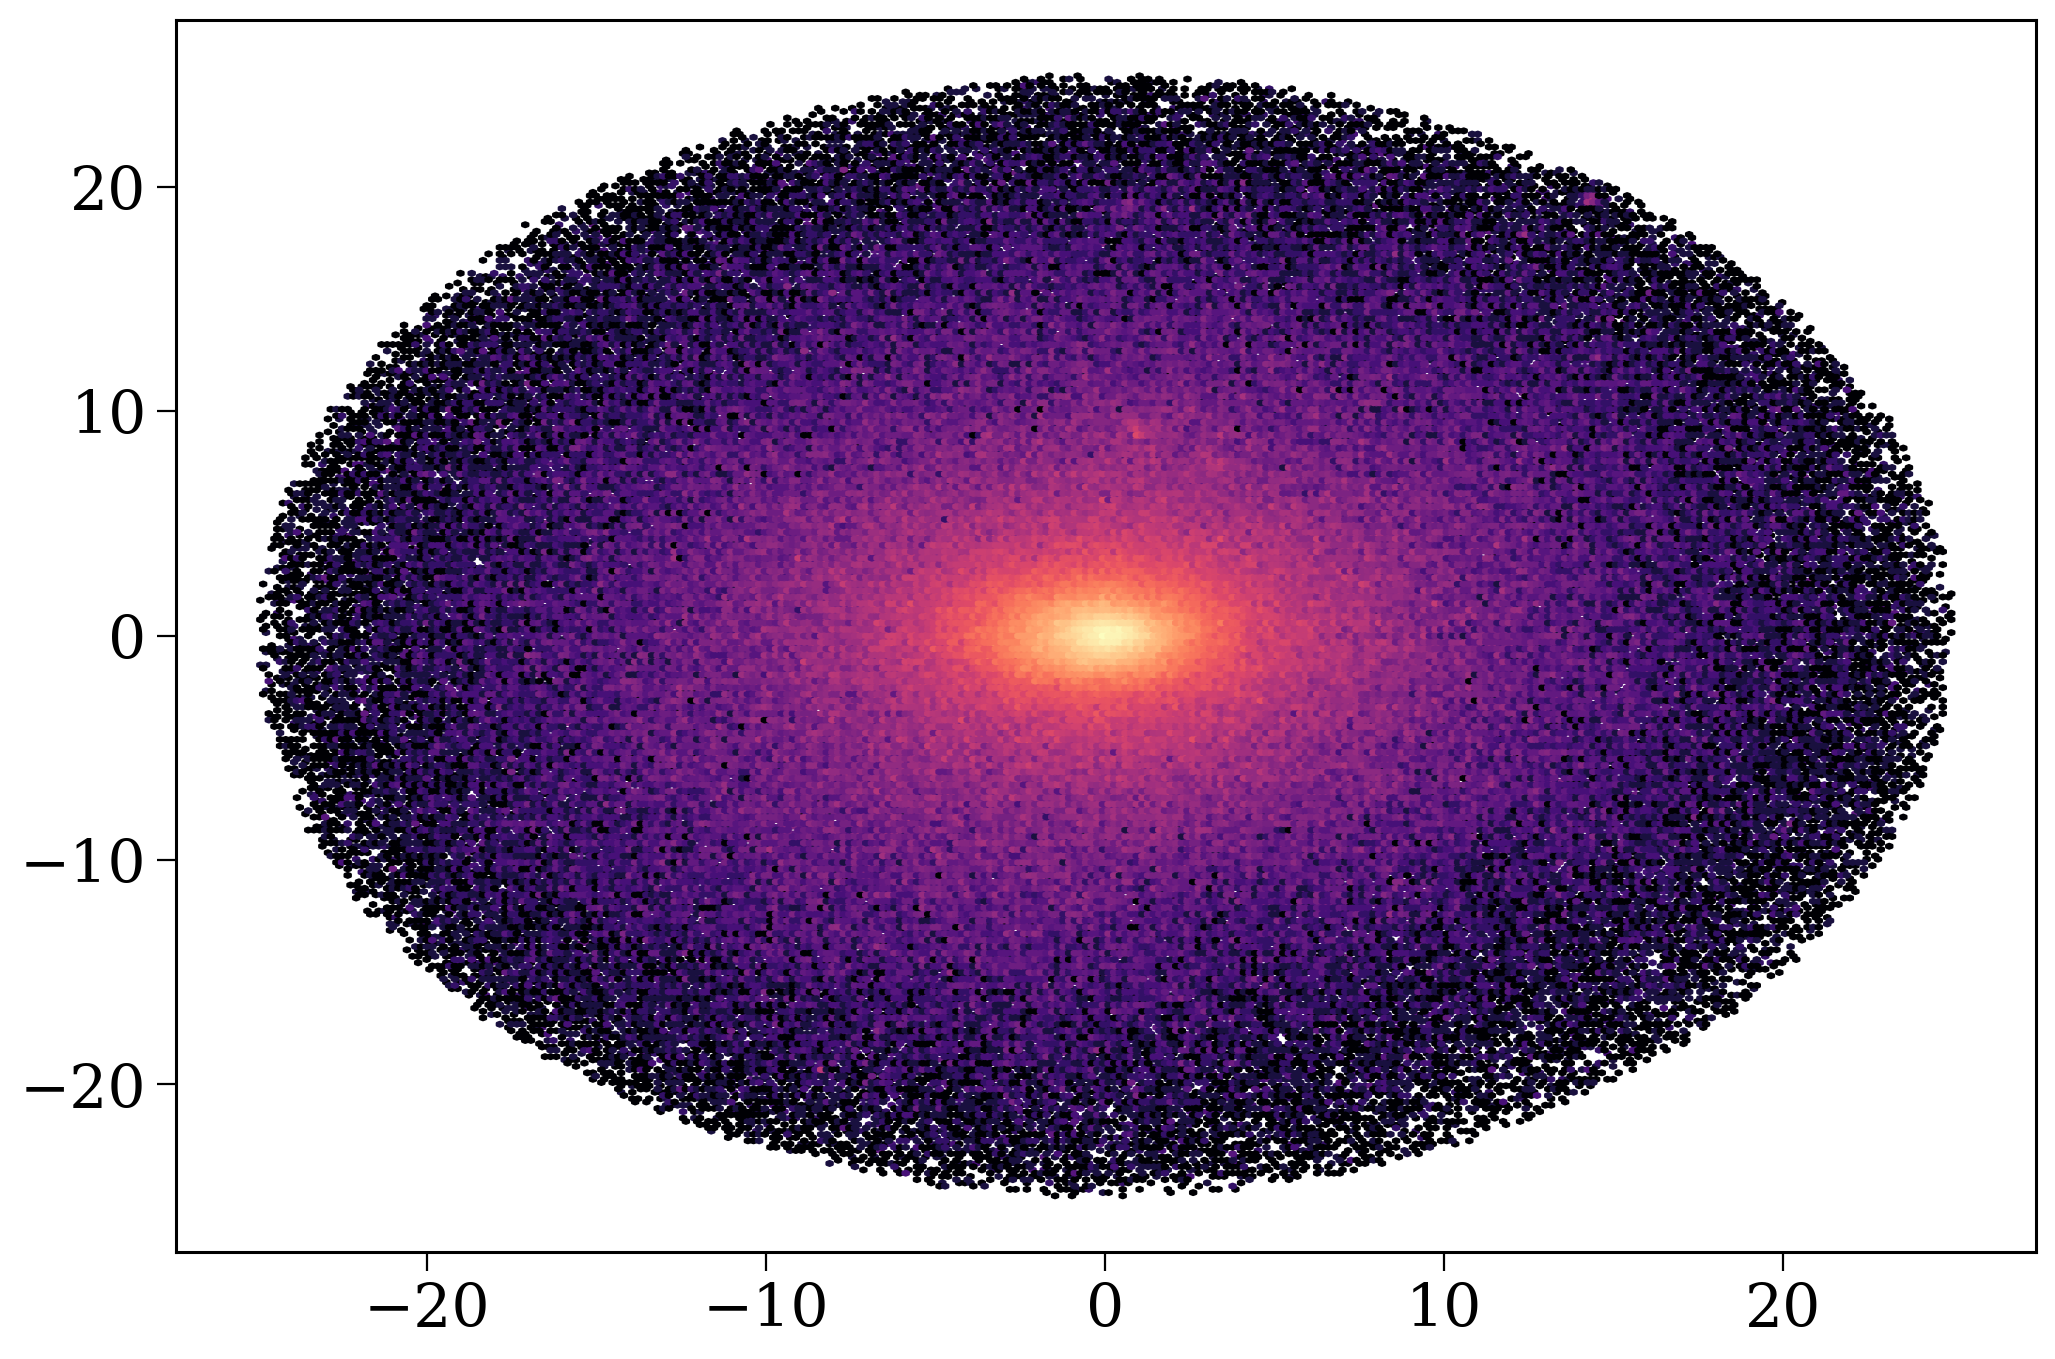

In [69]:
plt.hexbin(m11h_h1["x"][eps <= 0], m11h_h1["z"][eps <= 0], bins="log", gridsize=300, cmap="magma")

In [76]:
m11h_h1["mass"].sum()

SimArray(5.60007883e+10, 'Msol')

# Load the population

In [6]:
%%time
m11h = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/m11h-r-3-new-pot.h5")

CPU times: user 6.8 s, sys: 3.75 s, total: 10.5 s
Wall time: 19.5 s


In [8]:
%%time
m11h_half_Z = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/m11h-r-3-Z-0.5-same-initC")

CPU times: user 7.17 s, sys: 3.65 s, total: 10.8 s
Wall time: 23.4 s


In [24]:
def total_sn(p):
    return p.sn_1_merger.sum() + p.sn_2_merger.sum() + p.sn_1.sum() + p.sn_2.sum() + p.sn_1_singles.sum() + p.sn_2_singles.sum()

In [29]:
total_sn(m11h_half_Z) / total_sn(m11h)

1.054436637749262

In [30]:
total_sn(m11h)

531168

In [7]:
m11h.final_bpp["tphys"].max()

349.9716573800415

In [8]:
m11h_half_Z.final_bpp["tphys"].max()

349.9716573800415

In [7]:
plotting.set_sn_subpop_masks(m11h);

12056 177097 114777 225314


In [10]:
plotting.set_sn_subpop_masks(m11h_half_Z);

12971 194027 121590 231495


In [11]:
def merger_sn_fraction(p):
    return (p.sn_1_merger.sum() + p.sn_2_merger.sum()) / (p.sn_1_merger.sum() + p.sn_2_merger.sum() + p.sn_1.sum() + p.sn_2.sum() + p.sn_1_singles.sum() + p.sn_2_singles.sum())

In [12]:
merger_sn_fraction(m11h)

0.4263453370684981

In [13]:
(m11h.bpp["evol_type"]==6).sum()

162208

In [14]:
(m11h_half_Z.bpp["evol_type"]==6).sum()

139488

In [15]:
(m11h.final_bpp['sep'] == 0.0).sum()

421831

In [16]:
(m11h_half_Z.final_bpp['sep'] == 0.0).sum()

419542

In [8]:
f = np.load(f"/mnt/home/twagg/ceph/pops/sn_positions-m11h-r-3-new-pot.npz")
m11h.primary_sn_distances, m11h.secondary_sn_distances = f["arr_0"] * u.kpc, f["arr_1"] * u.kpc

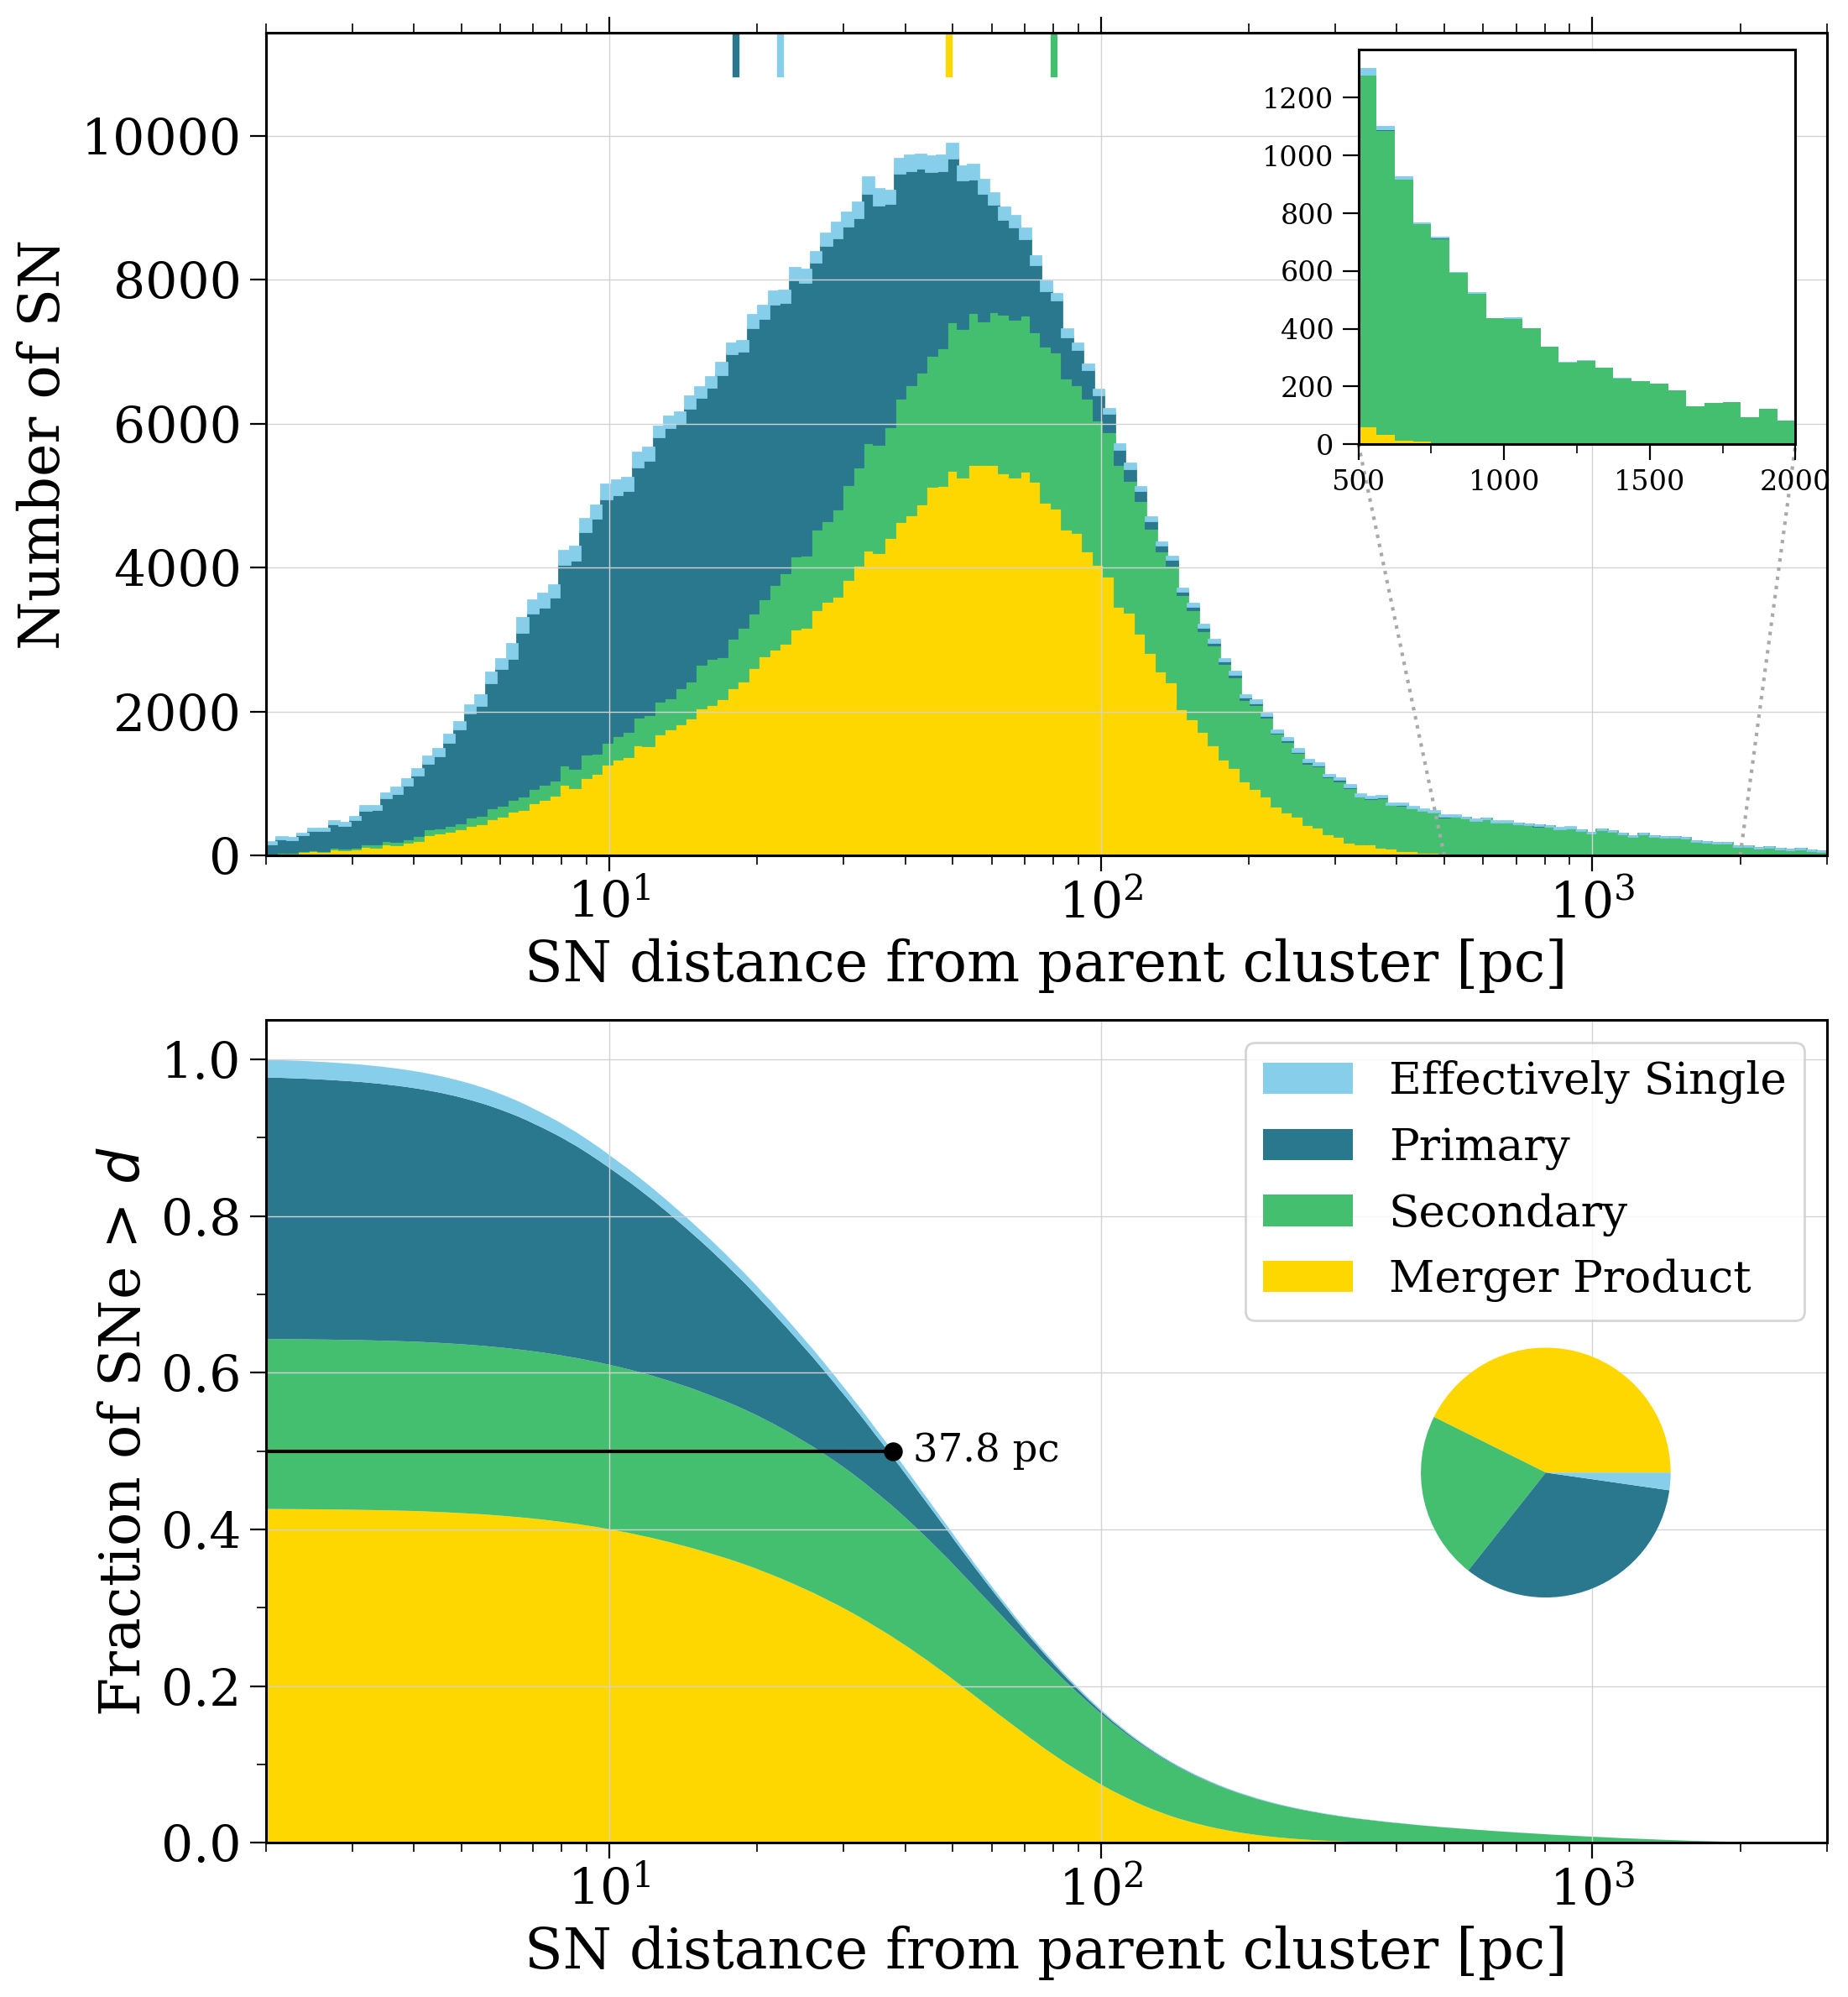

In [37]:
fig, axes = plotting.sandpile(m11h, bins=np.geomspace(2e0, 3e3, 150), show=False)
plt.savefig("../plots/sn_distance_hists/m11h-r-3-new-pot-new-style.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

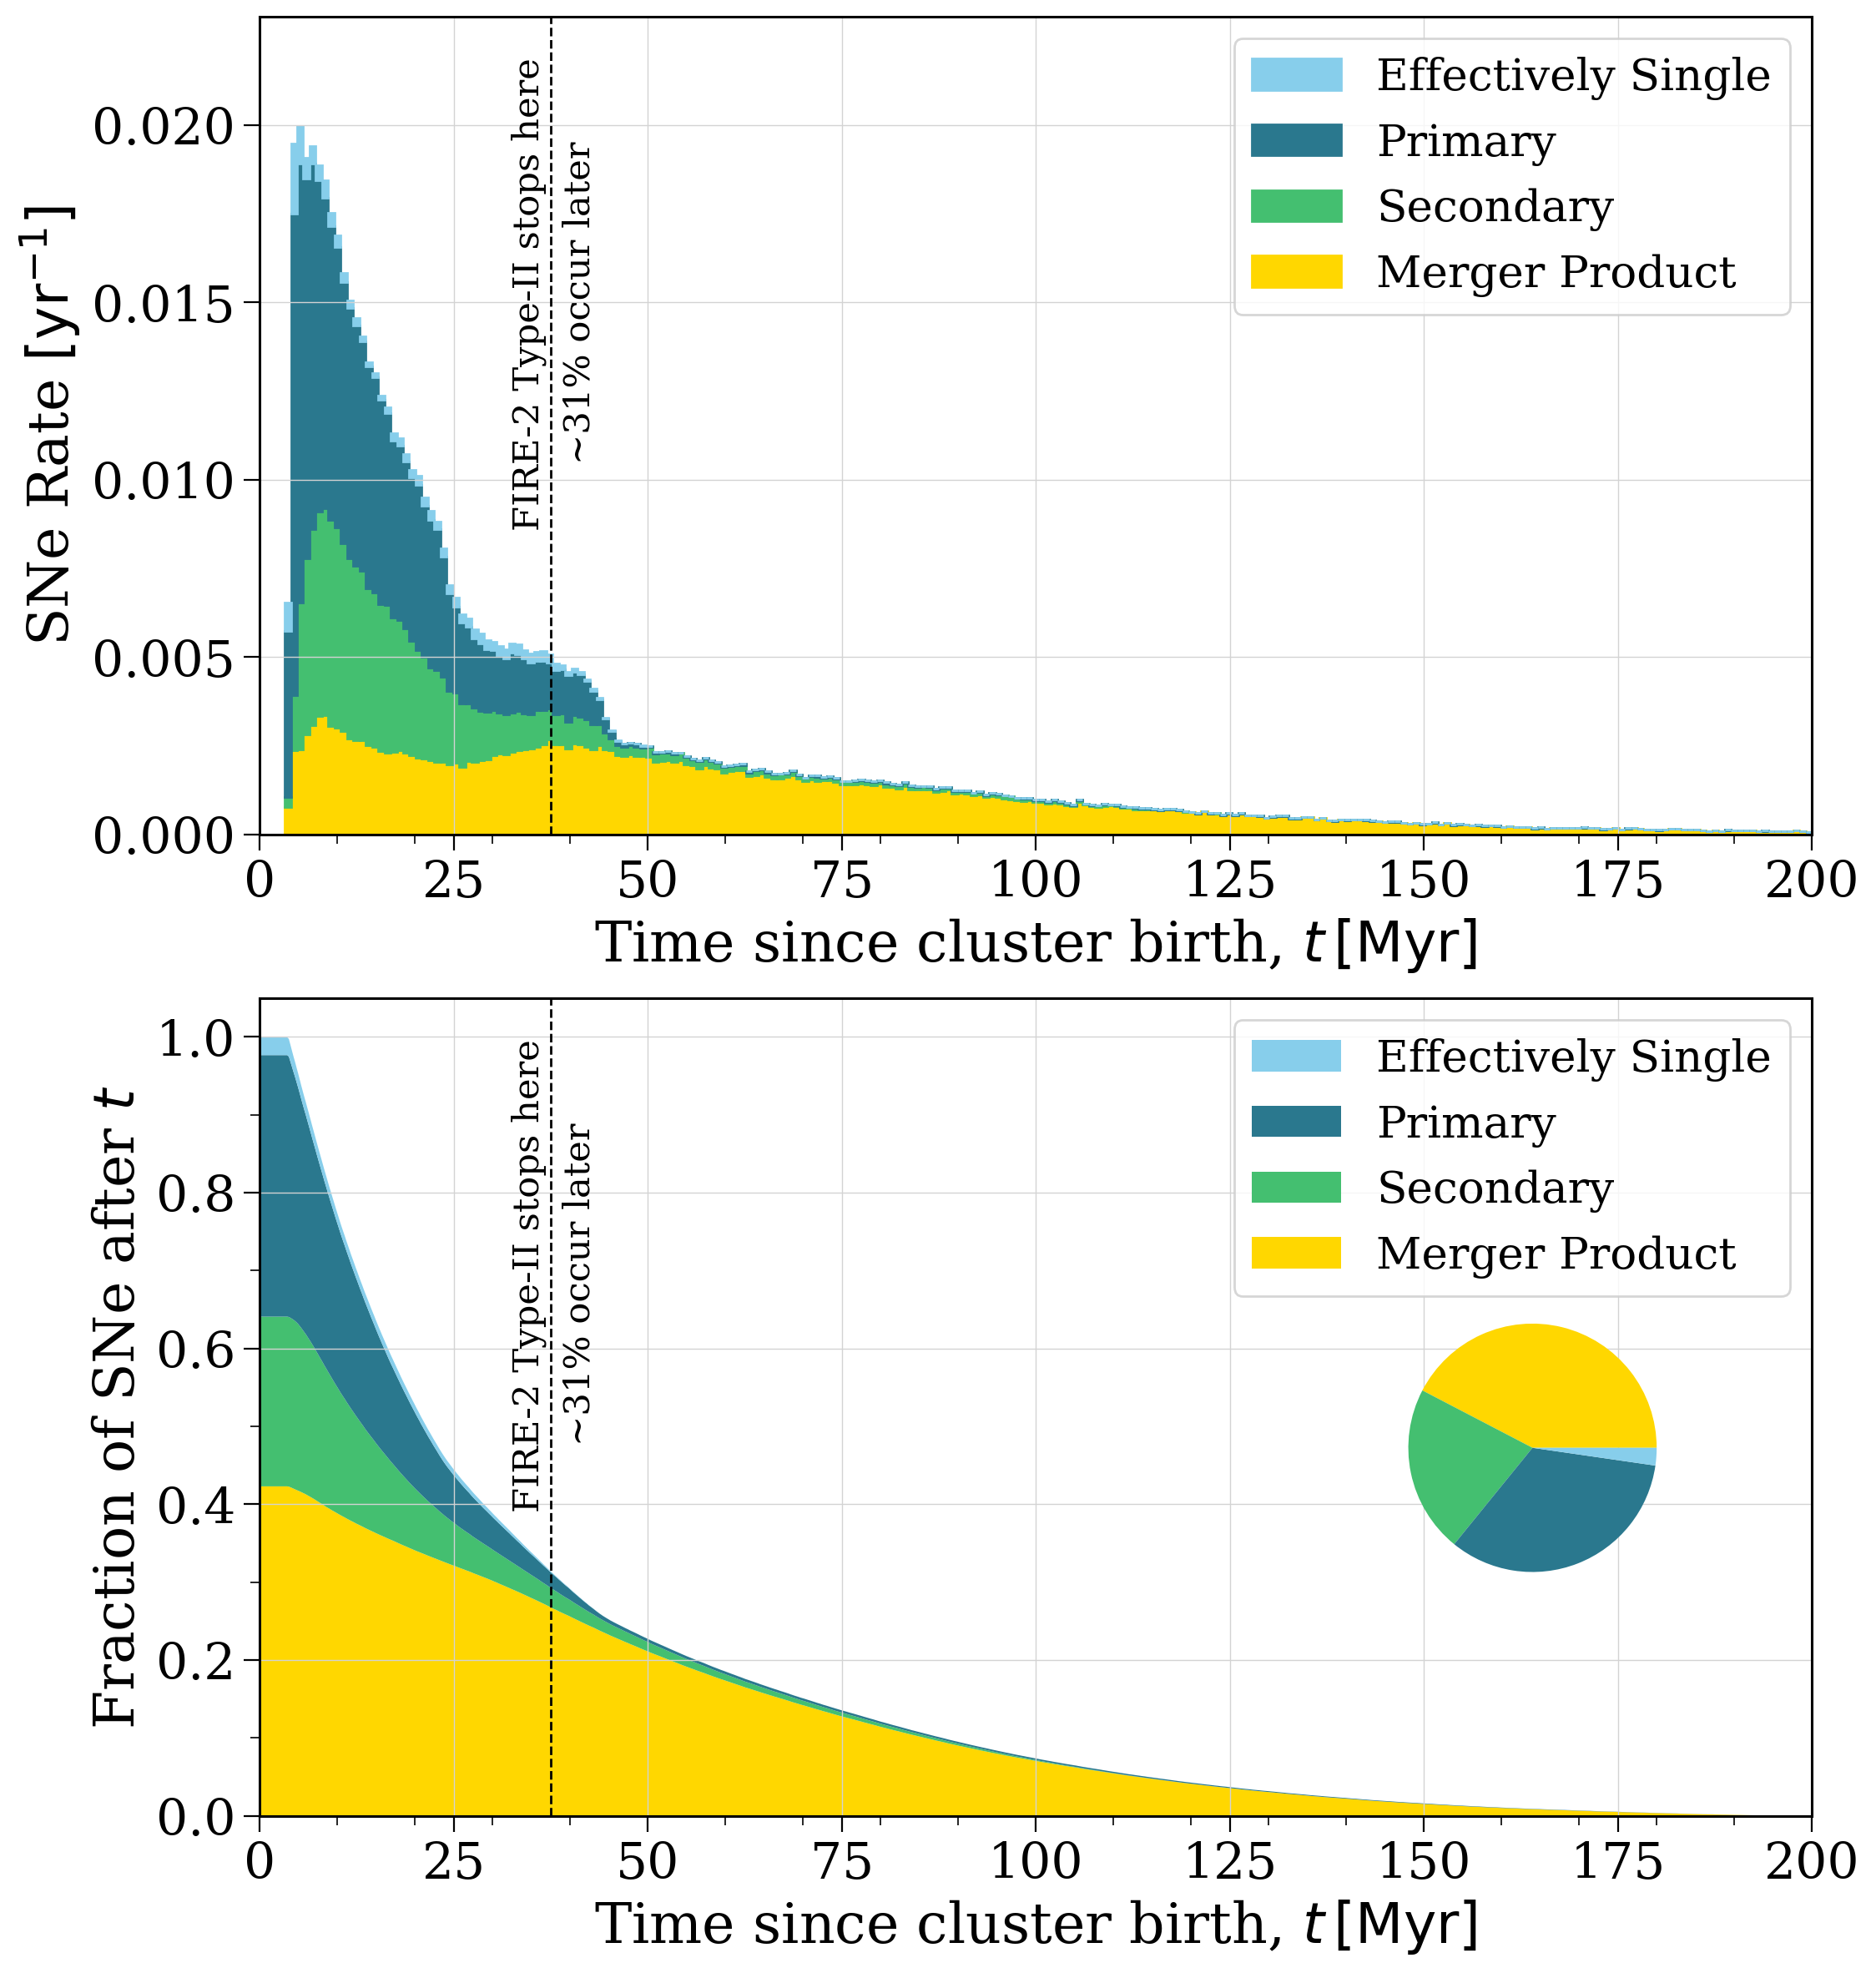

In [36]:
reload(plotting)
fig, axes = plotting.sandpile(m11h, bins=np.linspace(0, 200, 250), show=False, var="time")
plt.savefig("../plots/m11h-r-3-new-pot-time.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# Compare mergers across metallicity

## Which things merge?

In [17]:
mergers = {
    "regular": m11h.bpp["bin_num"][m11h.bpp["evol_type"]==6].values,
    "half": m11h_half_Z.bpp["bin_num"][m11h_half_Z.bpp["evol_type"]==6].values,
}

In [18]:
len(mergers["regular"]), len(mergers["half"])

(162208, 139488)

In [19]:
merge_in_both = np.intersect1d(mergers["regular"], mergers["half"])

In [20]:
m11h.sn_1_merger.sum() + m11h.sn_2_merger.sum()

226461

In [21]:
mergers["half"]

array([     3,     21,     24, ..., 778159, 778169, 778171])

## **WHEN** do they merge?

In [2]:
from importlib import reload

0.9999999999999999


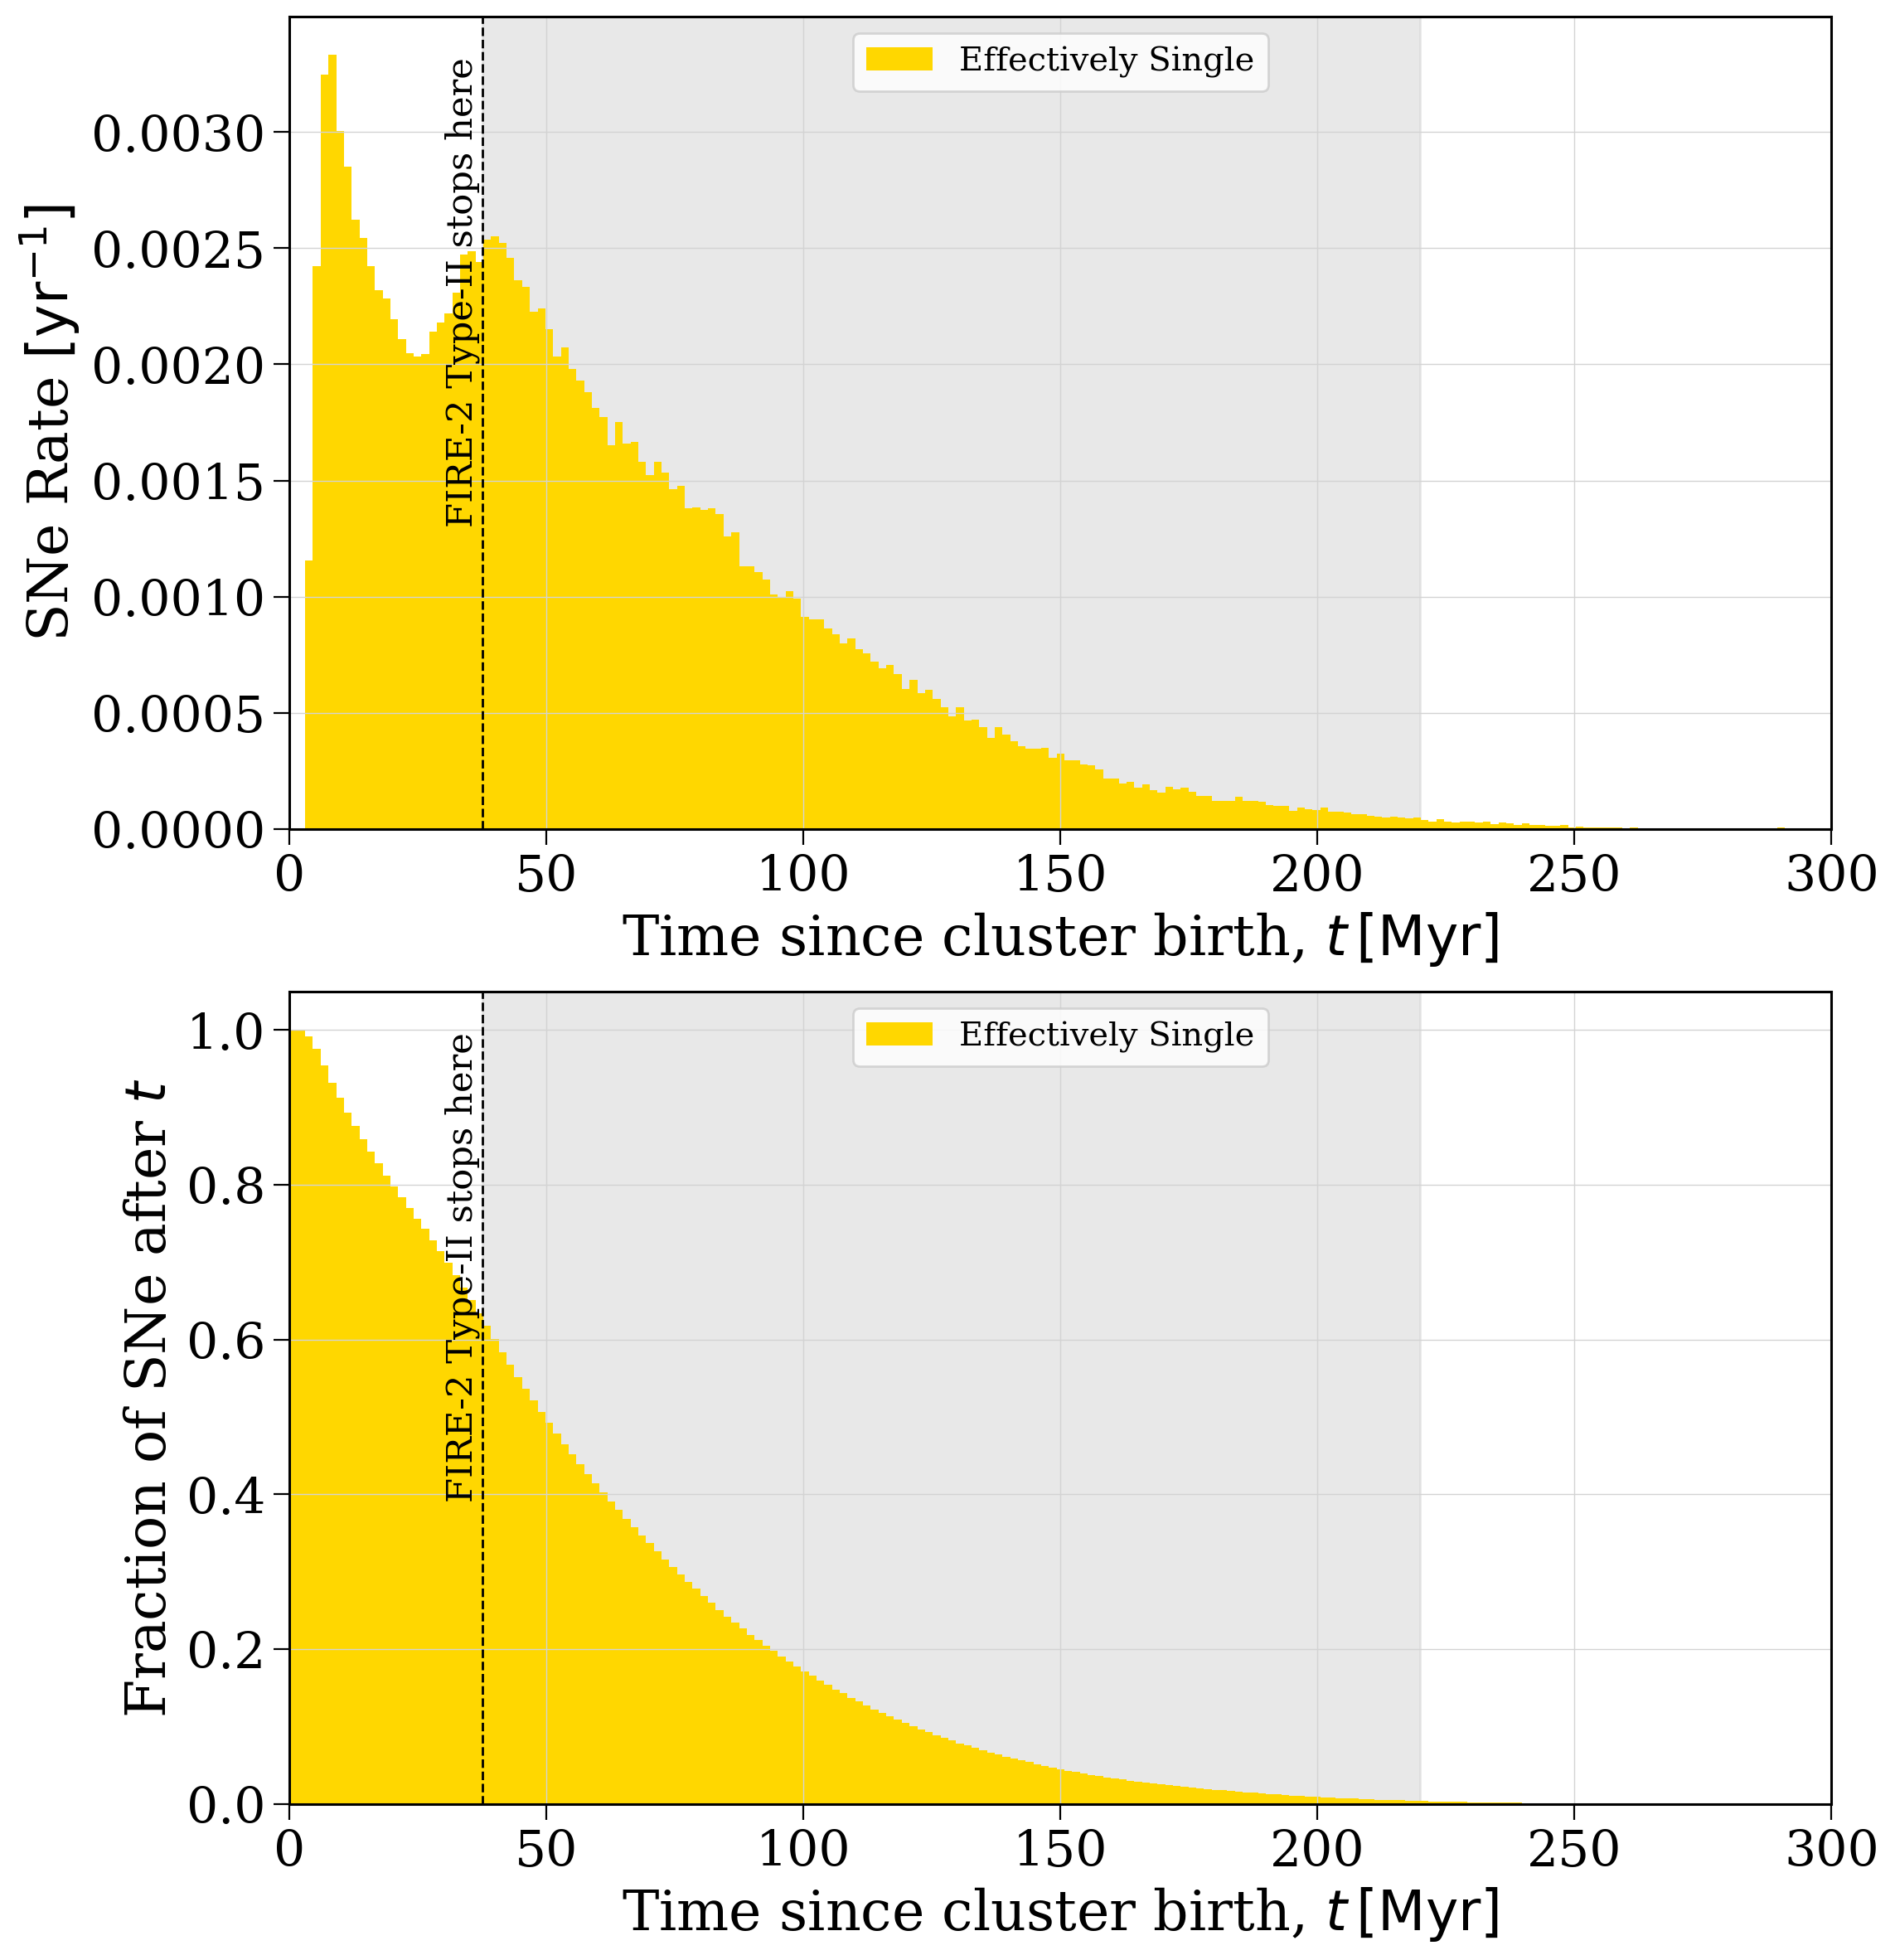

In [22]:
reload(plotting)
fig, axes = plotting.sn_time_histograms(m11h, bins=np.linspace(0, 300, 200), show=False)

for ax in axes:
    ax.set(xlim=(0, 300))

1.0


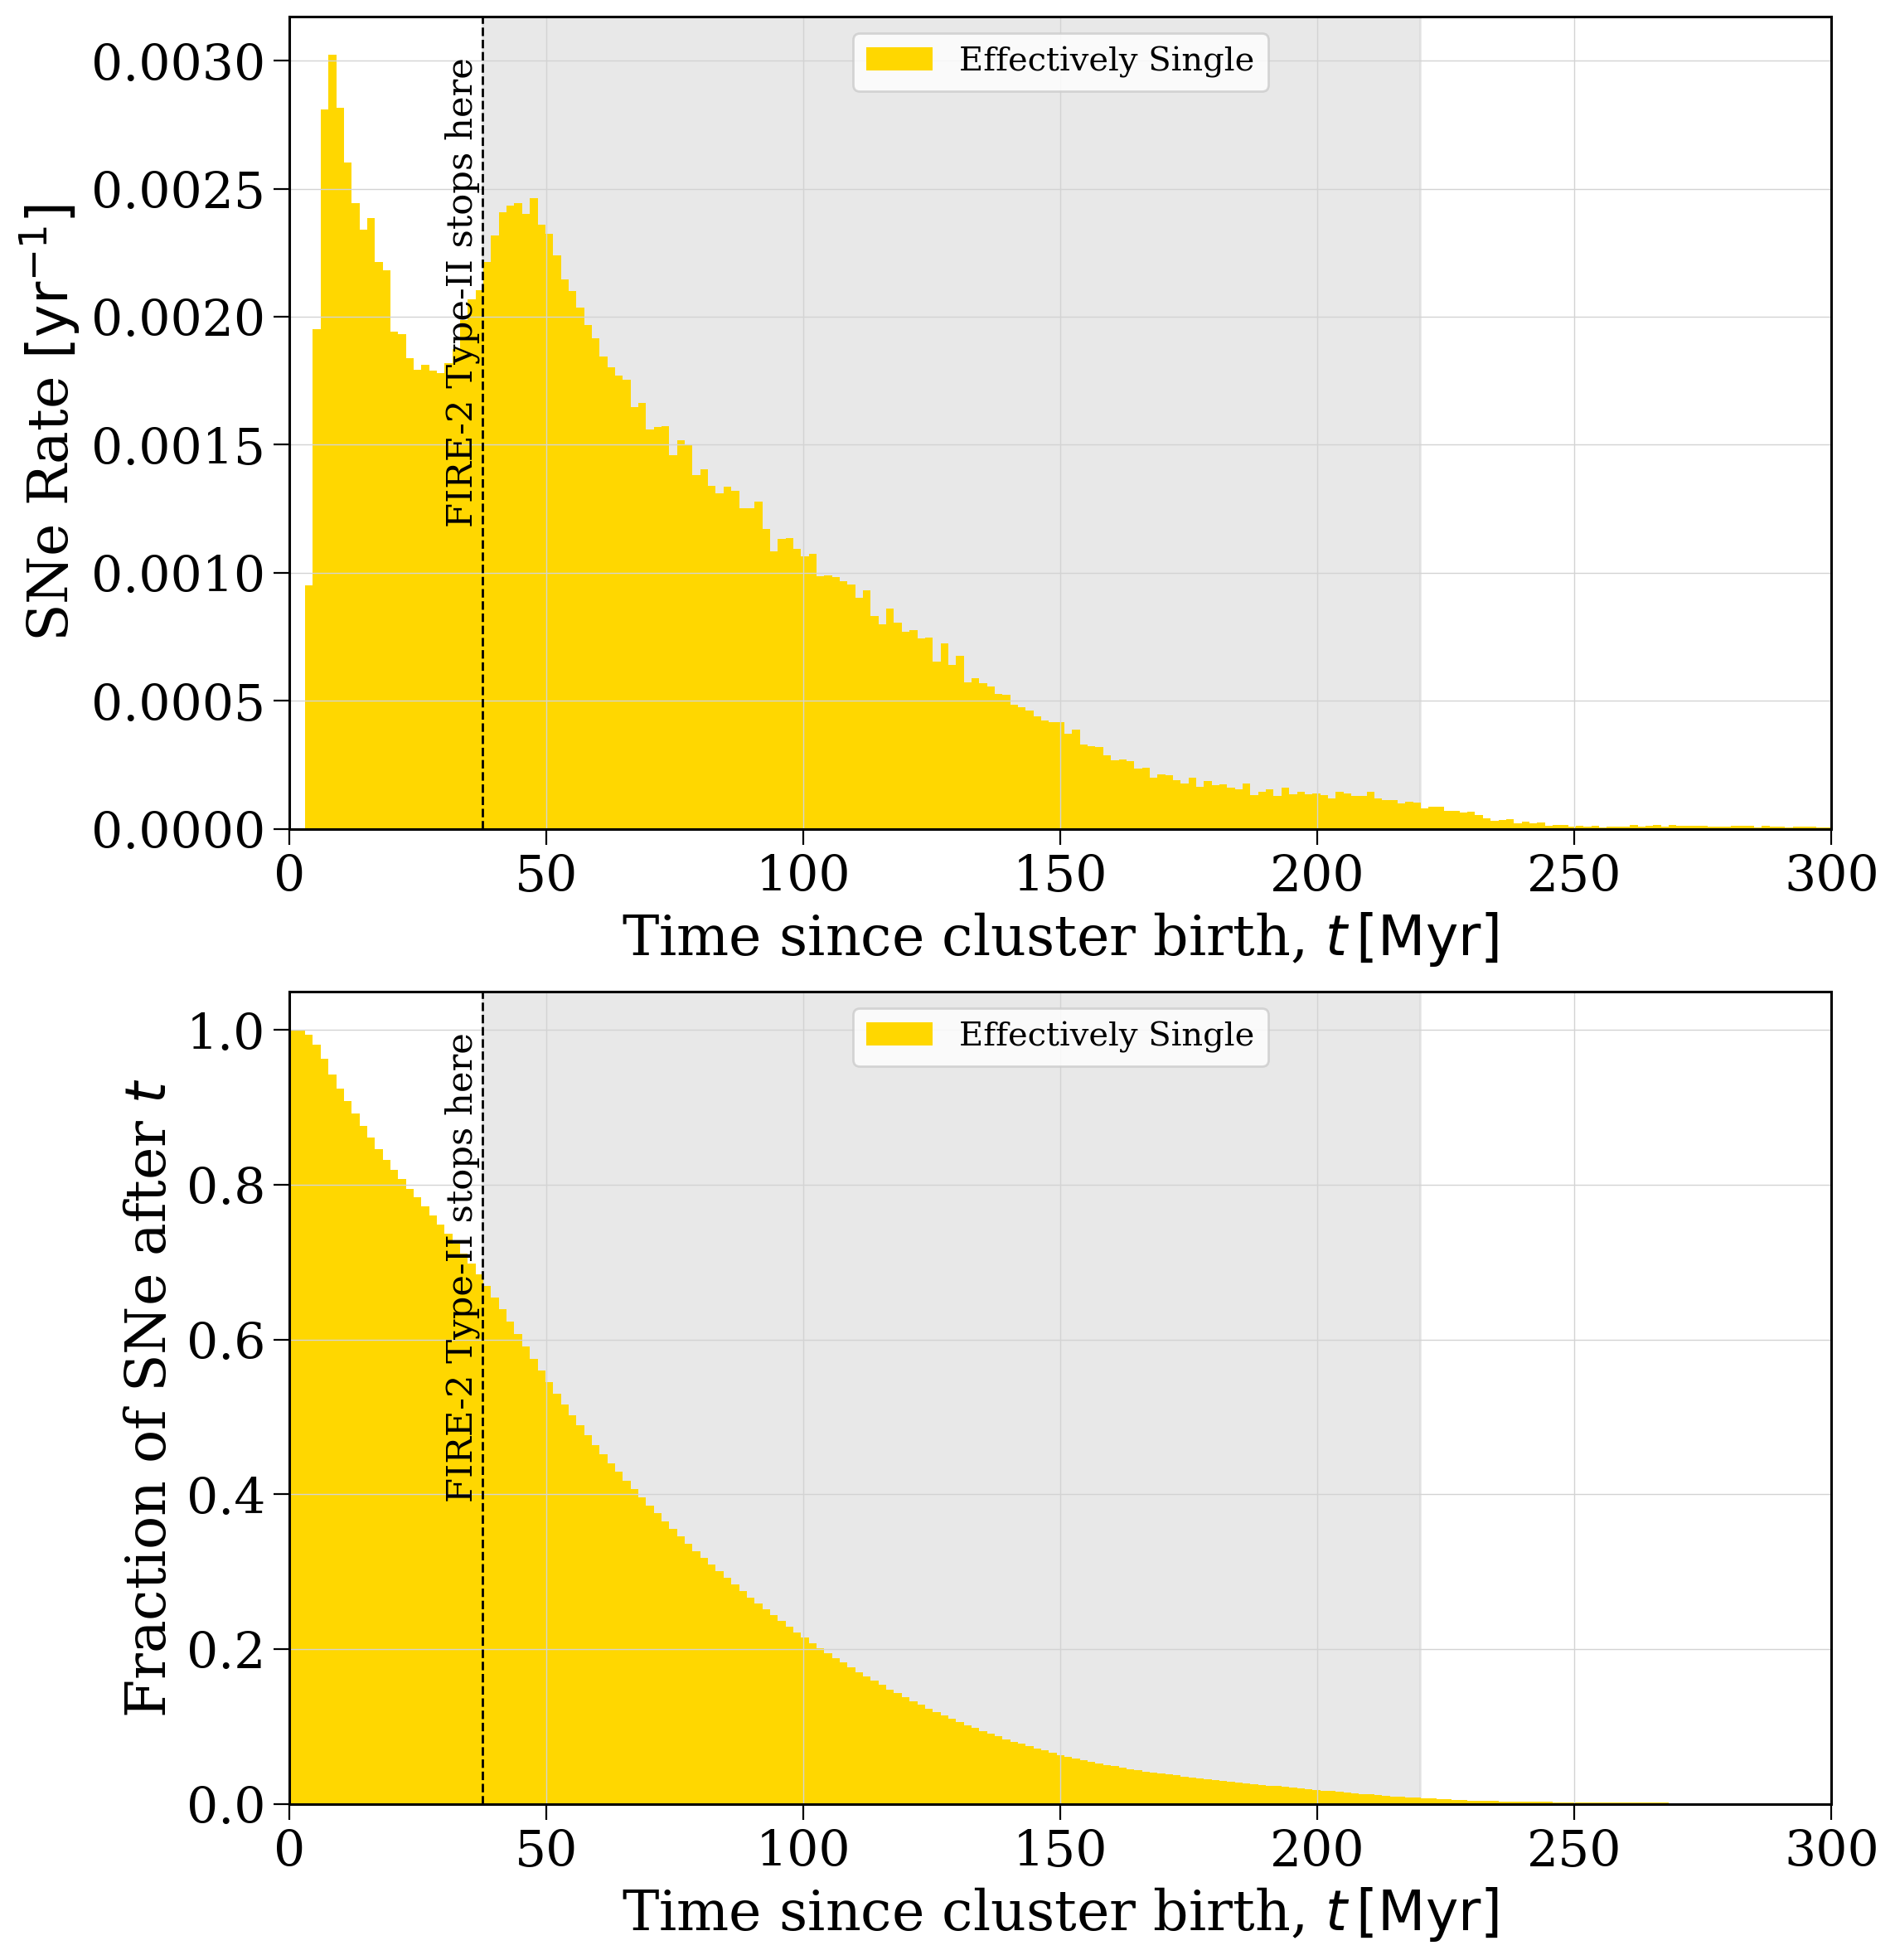

In [20]:
reload(plotting)
fig, axes = plotting.sn_time_histograms(m11h_half_Z, bins=np.linspace(0, 300, 200), show=False)

for ax in axes:
    ax.set(xlim=(0, 300))

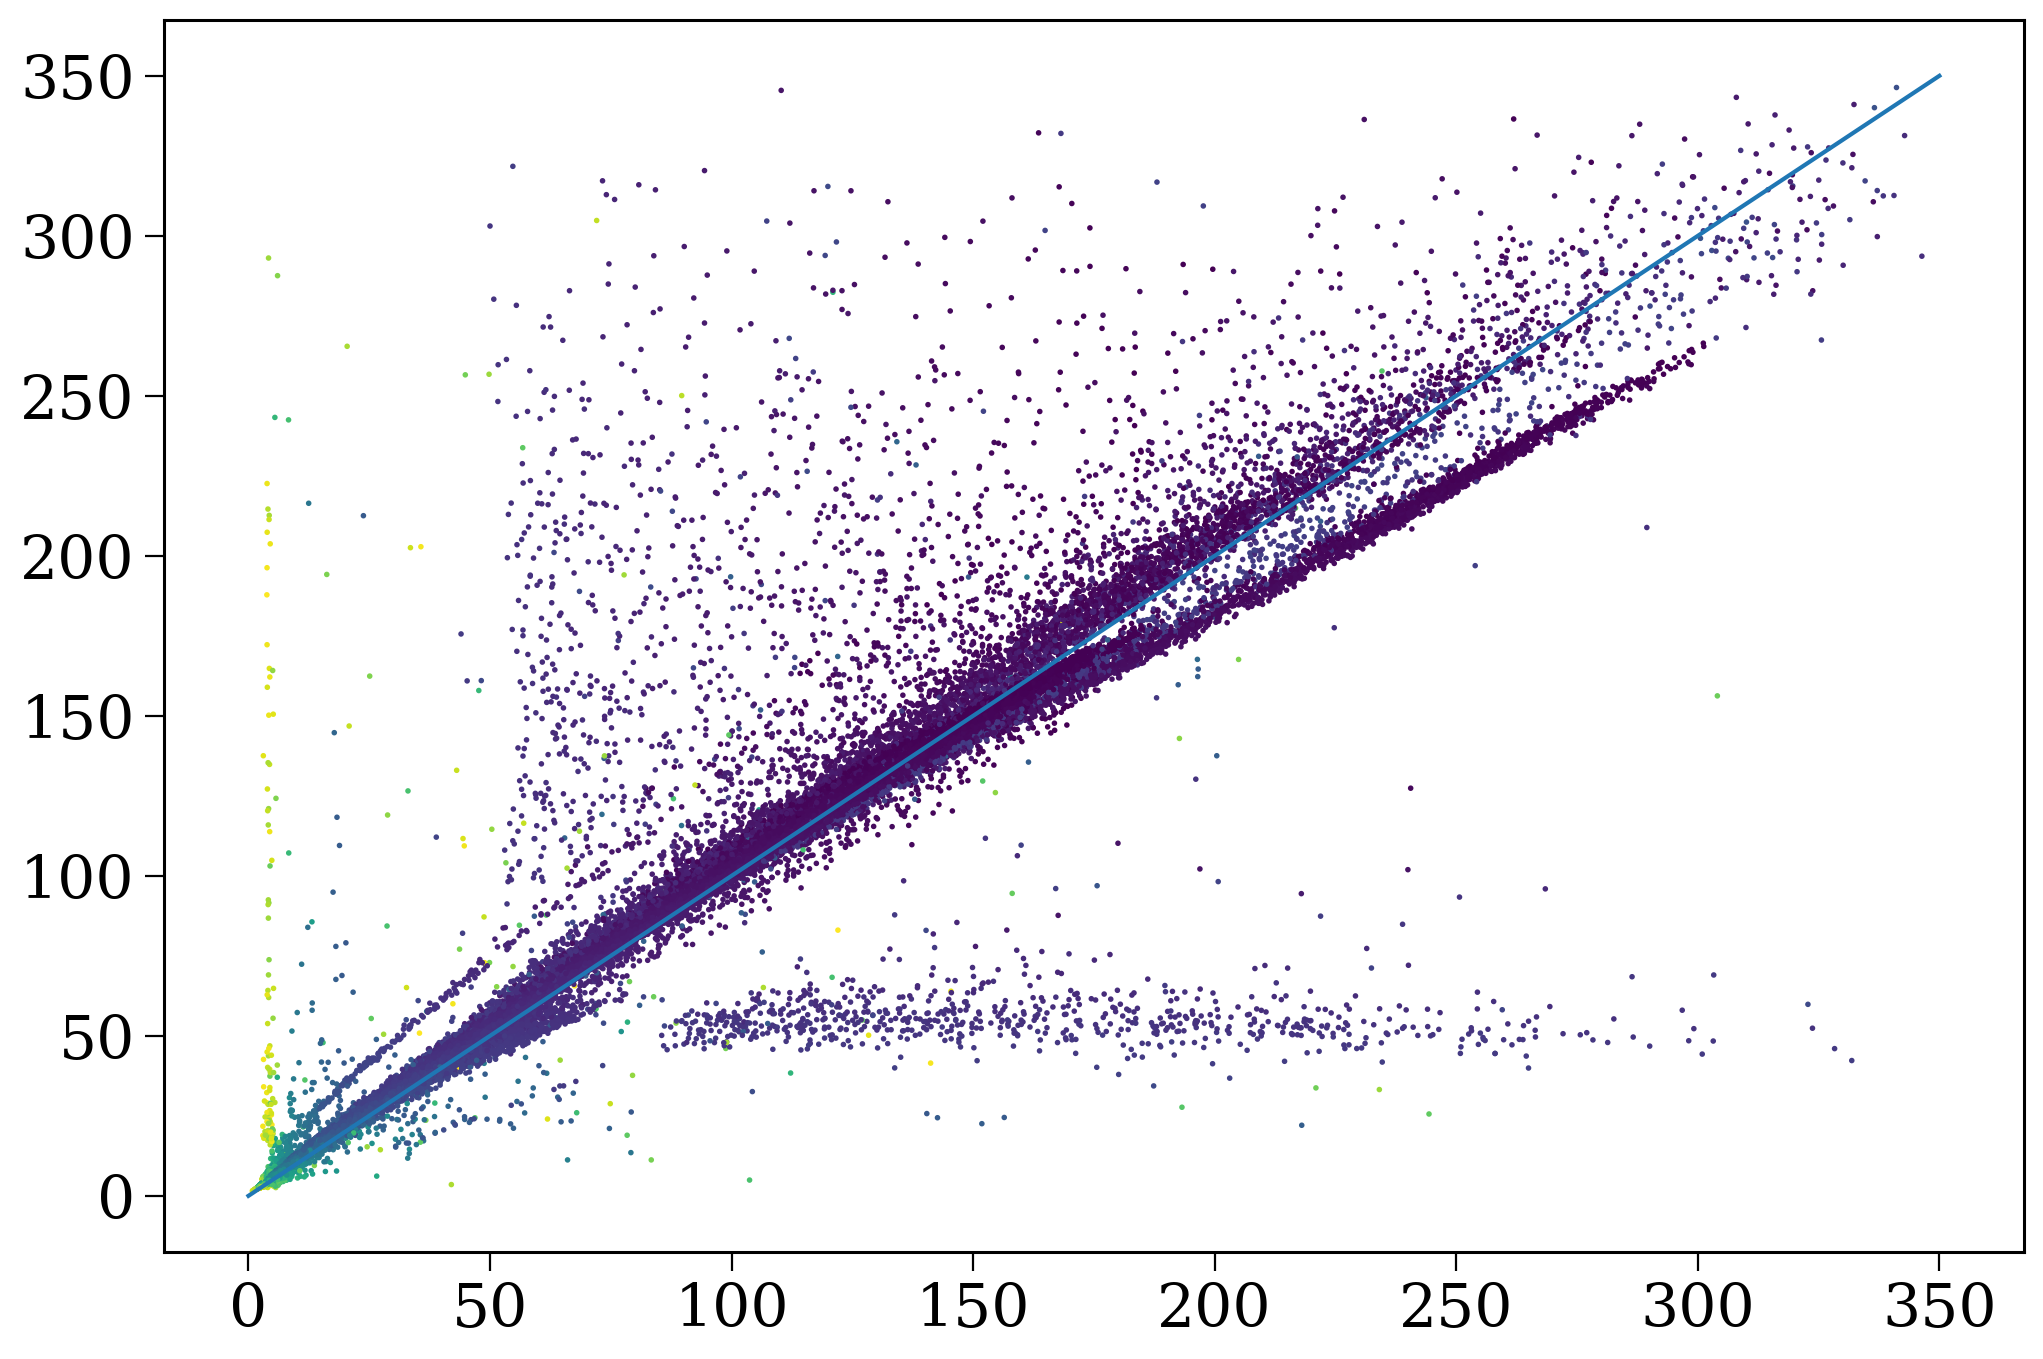

In [80]:
plt.scatter(m11h.bpp[m11h.bpp["evol_type"] == 6].loc[merge_in_both]["tphys"],
            m11h_half_Z.bpp[m11h_half_Z.bpp["evol_type"] == 6].loc[merge_in_both]["tphys"], s=1,
            c=np.log10(m11h.initC["mass_1"].loc[merge_in_both]))
plt.plot([0, 350], [0, 350])

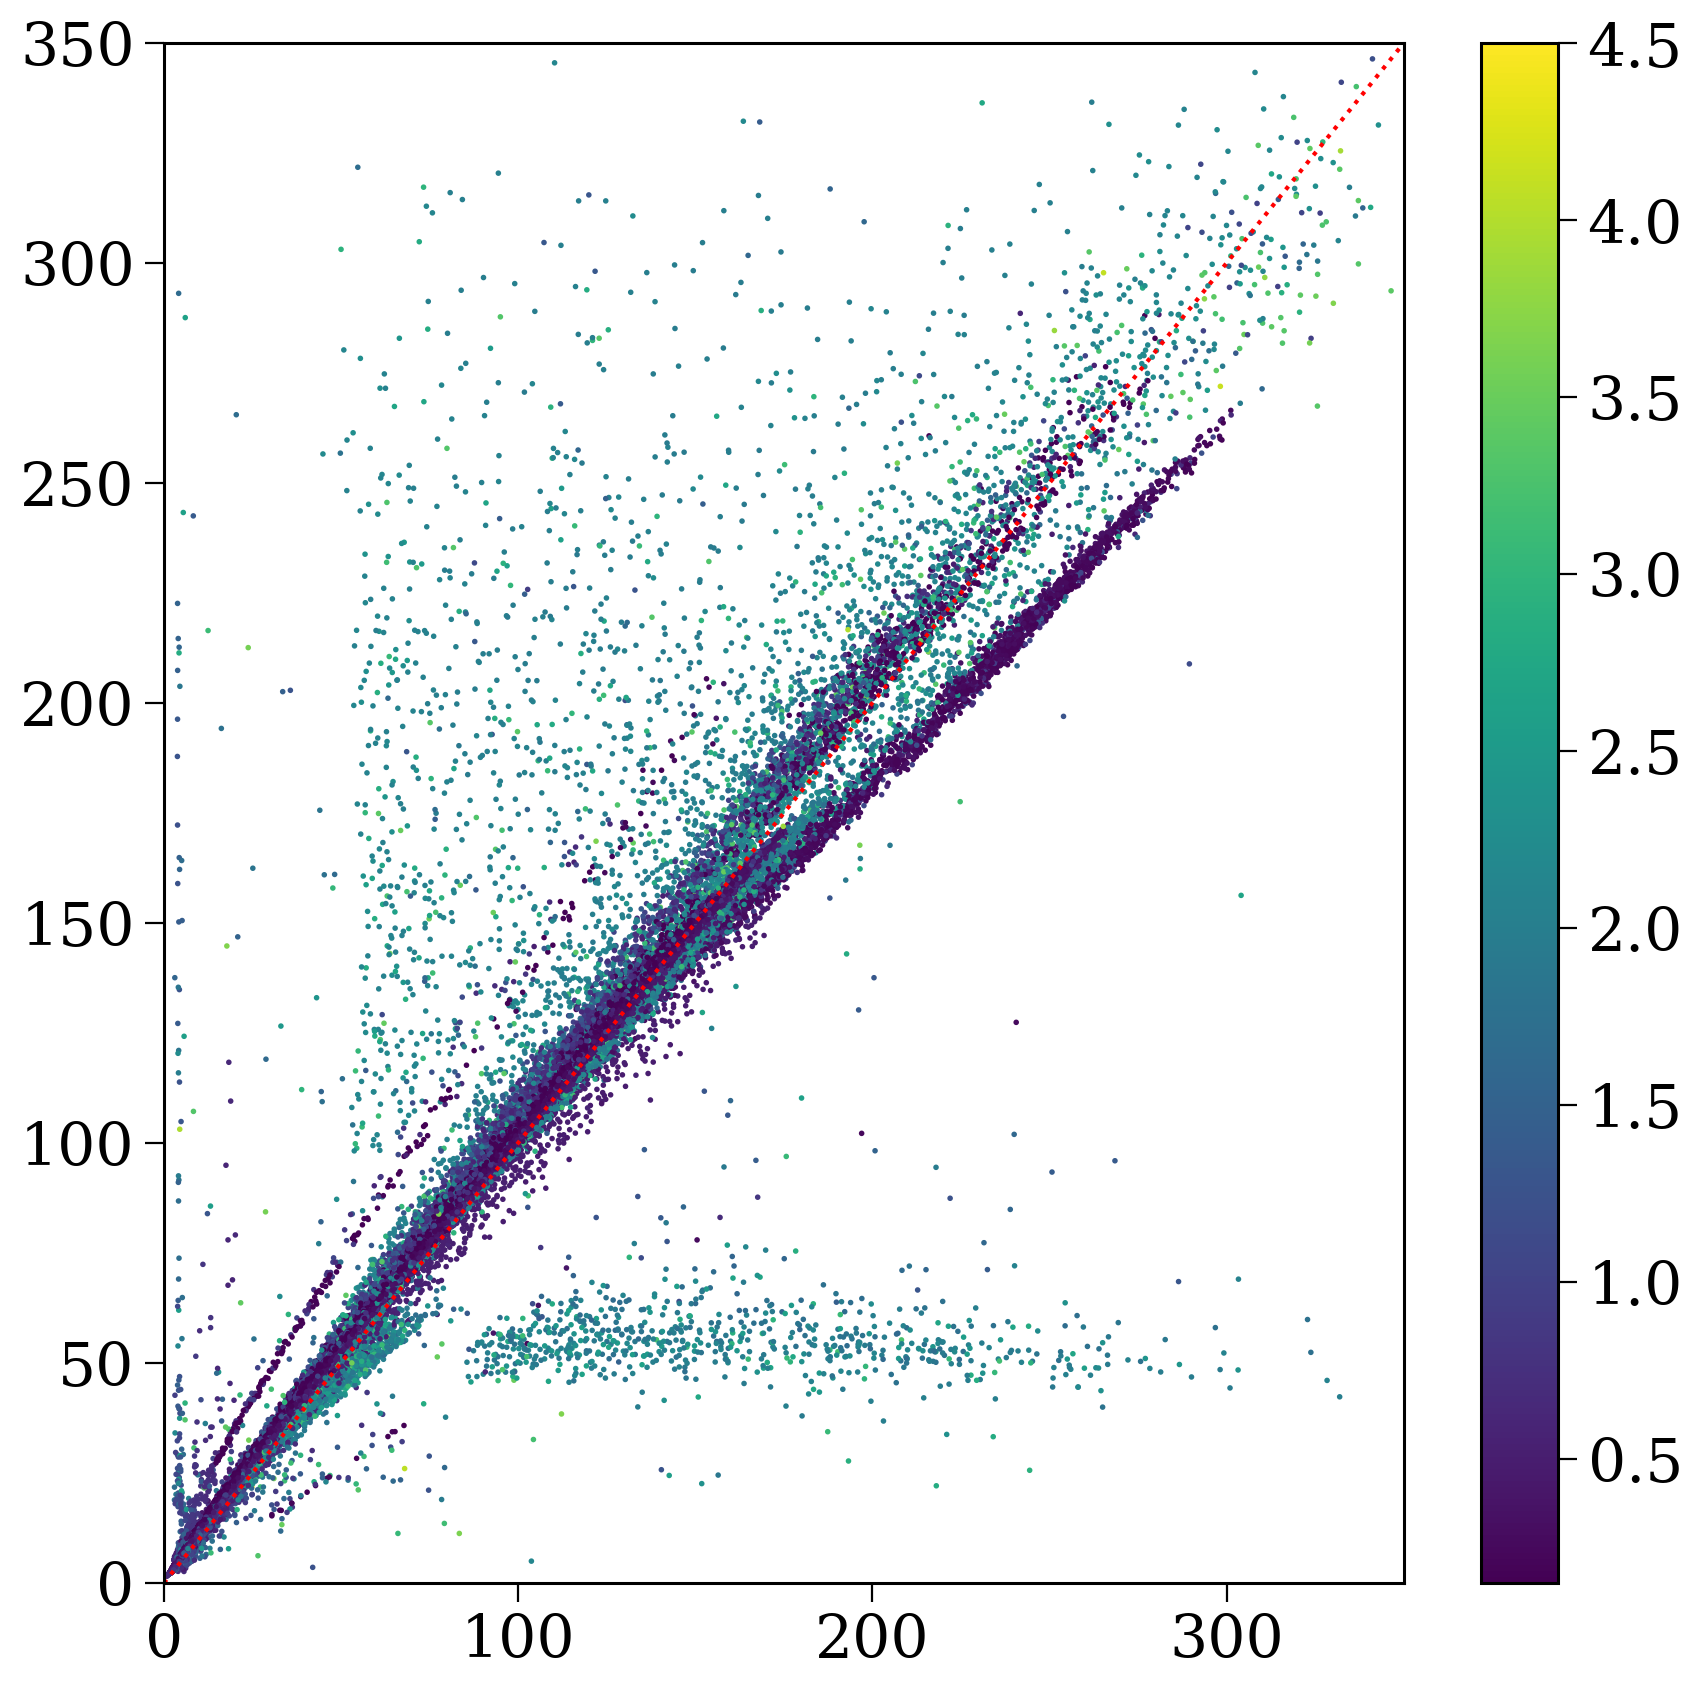

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(m11h.bpp[m11h.bpp["evol_type"] == 6].loc[merge_in_both]["tphys"],
            m11h_half_Z.bpp[m11h_half_Z.bpp["evol_type"] == 6].loc[merge_in_both]["tphys"], s=1,
            c=np.log10(m11h.initC["porb"].loc[merge_in_both]))
fig.colorbar(scatter)

ax.plot([0, 350], [0, 350], color="red", linestyle="dotted")

ax.set(xlim=(0, 350), ylim=(0, 350))

plt.show()

# More

In [25]:
import h5py as h5

In [33]:
with h5.File("/mnt/home/twagg/ceph/pops/m11h-r-3-new-pot.h5", "a") as f:
    f["initial_galaxy"].attrs["params"] = f["initial_galaxy"].attrs["params"].replace("Galaxy", "StarFormationHistory")

In [34]:
%%time
m11h = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/m11h-r-3-new-pot.h5")

CPU times: user 6.87 s, sys: 3.08 s, total: 9.95 s
Wall time: 21.4 s


In [35]:
f = np.load("/mnt/home/twagg/ceph/pops/sn_positions-m11h-r-3-new-pot.npz")
m11h.primary_sn_distances, m11h.secondary_sn_distances = f["arr_0"] * u.kpc, f["arr_1"] * u.kpc

In [36]:
plotting.set_sn_subpop_masks(m11h);

12056 177097 114777 225314


In [1]:
fig, axes = plotting.sn_distance_histograms(m11h, show=False)
axes[0].set_ylim(top=4400)
# plt.savefig("../plots/sn_distance_hists/m11h-r-3-new-pot.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

NameError: name 'plotting' is not defined

# Comparisons for Mathieu

In [33]:
merger_nums = m11h.bin_nums[m11h.final_bpp["sep"] == 0]

In [34]:
m11h.bpp[(m11h.bpp["evol_type"] == 6) & (m11h.bpp["kstar_1"] < 13) & (m11h.bpp["kstar_1"] < 14)]["bin_num"].values

array([     3,     19,     64, ..., 778124, 778127, 778146])

In [35]:
len(np.intersect1d(m11h.bin_nums[m11h.final_bpp["sep"] == 0],
                   m11h.bpp[(m11h.bpp["evol_type"] == 6) & (m11h.bpp["kstar_1"] < 13) & (m11h.bpp["kstar_1"] < 14)]["bin_num"].values))

52862

In [36]:
m11h.bpp.loc[20]

tphys     mass_1     mass_2  kstar_1  kstar_2         sep       porb  \
20    0.000000  35.877147  30.959054      1.0      1.0   50.485159   5.085245   
20    4.351817  33.101371  29.407627      1.0      1.0   48.817673   4.999960   
20    5.231180  29.675138  31.610522      2.0      1.0   48.482130   4.997643   
20    5.239216  20.990970  40.281109      4.0      1.0   53.135742   5.734836   
20    5.241407   9.594103  51.671969      4.0      1.0  141.807727  25.004143   
20    5.249856   9.583076  51.656557      7.0      1.0  141.824043  25.013857   
20    5.996571   6.647494  49.488605      8.0      1.0  154.614184  29.738910   
20    6.043653   6.413189  49.350610      8.0      1.0  155.627648  30.131872   
20    6.043653   2.351865  49.350610     13.0      1.0   -1.000000  -1.000000   
20    7.307456   2.351865  43.600694     13.0      2.0   -1.000000  -1.000000   
20    7.312598   2.351865  43.043831     13.0      4.0   -1.000000  -1.000000   
20    7.486739   2.351865  17.420896     13.0      7.0   -1.000000  -1.000000   
20    7.827853   2.351865  10.859652     13.0      8.0   -1.000000  -1.000000   
20    7.851847   2.351865  10.499071     13.0      8.0   -1.000000  -1.000000   
20    7.851847   2.351865   6.697269     13.0     14.0   -1.000000  -1.000000   
20  200.882857   2.351865   6.697269     13.0     14.0   -1.000000  -1.000000   

         ecc     RRLO_1    RRLO_2  evol_type        aj_1        aj_2  \
20  0.229129   0.572014  0.556541        1.0    0.000000    0.000000   
20  0.000000   1.000628  0.808984        3.0    4.497814    4.457550   
20  0.000000   1.306543  0.968517        2.0    5.839683    4.634303   
20  0.000000  90.049839  0.696675        2.0    5.847719    3.081426   
20  0.000000   0.659637  0.221606        4.0    5.849909    2.107634   
20  0.000000   0.026175  0.221990        2.0    0.011180    2.116371   
20  0.000000   0.020896  0.236565        2.0    0.883799    2.913888   
20  0.000000   0.020896  0.236565       15.0    0.930830    2.964871   
20 -1.000000   0.000000 -2.000000       11.0    0.930830    2.964871   
20 -1.000000   0.000100  0.000100        2.0    1.263803    4.483225   
20 -1.000000   0.000100  0.000100        2.0    1.268945    4.488367   
20 -1.000000   0.000100  0.000100        2.0    1.443086    0.164548   
20 -1.000000   0.000100  0.000100        2.0    1.784200    0.610700   
20 -1.000000   0.000100  0.000100       16.0    1.808193    0.634343   
20 -1.000000   0.000100  0.000100        2.0    1.808193    0.000000   
20 -1.000000   0.000100  0.000100       10.0  194.839204  193.031011   

           tms_1         tms_2   massc_1    massc_2        rad_1        rad_2  \
20  5.058972e+00  5.642230e+00  0.000000   0.000000     8.720845     7.932231   
20  5.358888e+00  5.883862e+00  0.000000   0.000000    19.012019    14.561891   
20  5.839683e+00  5.550445e+00  9.354097   0.000000    23.656689    18.049897   
20  5.839683e+00  4.694410e+00  9.541230   0.000000  1550.936487    16.151943   
20  5.839683e+00  4.114205e+00  9.549847   0.000000    23.068553    16.565035   
20  6.647459e-01  4.114767e+00  0.000000   0.000000     0.915260    16.597956   
20  8.837986e-01  4.198433e+00  4.286695   0.000000     0.727306    20.274854   
20  8.837986e-01  4.204083e+00  4.787794   0.000000     1.250225    20.604519   
20  8.837986e-01  4.204083e+00  4.787794   0.000000     1.250225    20.604519   
20  1.000000e+10  4.483224e+00  2.351865  15.728273     0.000014    37.472560   
20  1.000000e+10  4.483224e+00  2.351865  16.042809     0.000014  1912.710087   
20  1.000000e+10  4.588058e-01  2.351865   0.000000     0.000014     1.375398   
20  1.000000e+10  6.106997e-01  2.351865   7.508169     0.000014     0.985460   
20  1.000000e+10  6.106997e-01  2.351865   8.035196     0.000014     1.085930   
20  1.000000e+10  6.106997e-01  2.351865   6.697269     0.000014     0.000028   
20  1.000000e+10  1.000000e+10  2.351865   6.697269     0.000014     0.000028   

      mass0_1    mass0_2    

In [37]:
def identify_stellar_mergers(p):
    p.bpp["row_ind"] = np.arange(len(p.bpp))
    zero_sep_rows = p.bpp[p.bpp["sep"] == 0].drop_duplicates(subset="bin_num", keep="first")
    just_before_merger = p.bpp.iloc[zero_sep_rows["row_ind"] - 1]
    return just_before_merger[(just_before_merger["kstar_1"] < 13) & (just_before_merger["kstar_2"] < 13)]["bin_num"].values

In [71]:
p = m11h

In [72]:
p.bpp["row_ind"] = np.arange(len(p.bpp))
zero_sep_rows = p.bpp[p.bpp["sep"] == 0].drop_duplicates(subset="bin_num", keep="first")
just_before_merger = p.bpp.iloc[zero_sep_rows["row_ind"] - 1]

In [74]:
just_before_merger

tphys    mass_1     mass_2  kstar_1  kstar_2         sep  \
1        87.523216  0.885136   8.555384     11.0      2.0  155.915573   
6        86.733980  0.881006   9.379346     11.0      2.0  186.315730   
7       117.618894  4.755373   2.974381      3.0      1.0  103.202472   
9        75.469534  0.895223  10.303265     11.0      2.0  185.269497   
11       40.531737  1.619517   7.615063      7.0      2.0   21.666866   
...            ...       ...        ...      ...      ...         ...   
776960  166.988798  0.728463   7.429086      7.0      2.0  142.258917   
776961   43.552015  7.271231   3.023227      1.0      1.0   20.144492   
776963   79.302540  5.606332   1.901801      3.0      1.0  102.896175   
776964  100.759372  5.269319   0.937962      5.0      1.0  755.112497   
776965  104.973557  0.860889   3.006098      7.0      1.0    4.781856   

              porb  ecc    RRLO_1    RRLO_2  evol_type        aj_1  \
1        73.435903  0.0  0.000287  1.000652        7.0   15.776749   
6        92.016414  0.0  0.000248  1.001228        7.0    4.681858   
7        43.704329  0.0  1.004496  0.066328        7.0  117.846971   
9        87.337015  0.0  0.000251  1.001421        7.0    1.483209   
11        3.846429  0.0  0.063034  1.000382        7.0    4.844574   
...            ...  ...       ...       ...        ...         ...   
776960   68.851207  0.0  0.006724  1.000037        7.0   28.339777   
776961    3.265915  0.0  1.001942  0.350007        3.0   44.027056   
776963   44.147389  0.0  1.340203  0.055187        7.0   79.833345   
776964  965.248031  0.0  1.001985  0.004515        7.0  101.087747   
776965    0.616283  0.0  0.137366  1.000976        3.0    0.081918   

              aj_2         tms_1         tms_2   massc_1   massc_2  \
1        32.556523  1.000000e+10     32.479903  0.885136  1.772622   
6        27.314985  1.000000e+10     27.253505  0.881006  2.007555   
7       117.616690  1.173473e+02    387.526072  0.803759  0.000000   
9        23.005939  1.000000e+10     22.960029  0.895223  2.276982   
11       41.007576  7.109455e+00     40.991440  0.000000  1.493714   
...            ...           ...           ...       ...       ...   
776960   42.923156  4.693917e+01     42.807101  0.000000  1.466113   
776961   43.547933  4.478923e+01    377.666507  0.000000  0.000000   
776963   77.128737  7.953456e+01   1392.427068  1.006426  0.000000   
776964  100.560520  8.754557e+01  14849.806606  1.289731  0.000000   
776965  104.972211  3.044429e+01    383.487641  0.000000  0.000000   

             rad_1       rad_2   mass0_1    mass0_2         lum_1  \
1         0.009345   89.783459  0.885132   8.555384      0.070706   
6         0.009391  108.773602  0.881002   9.379346      0.290000   
7        43.550454    2.321257  4.755373   2.974381    704.109644   
9         0.009232  109.309060  0.895219  10.303265      1.085974   
11        0.349695   11.172562  1.619517   7.615063   2018.238728   
...            ...         ...       ...        ...           ...   
776960    0.196671   82.473334  0.728463   7.429086    123.293896   
776961    9.212407    2.158143  7.271231   3.023227   4744.197881   
776963   65.436142    1.648557  5.614231   1.901801   1270.359026   
776964  401.547029    0.830895  5.388083   0.937962  15881.199932   
776965    0.182325    2.342894  0.860889   3.006098    145.594859   

               lum_2        teff_1        teff_2      radc_1    radc_2  \
1        6383.958693  30927.569848   5469.453839    0.009345  0.308679   
6        8550.550846  43904.262306   5345.722106    0.009391  0.335982   
7          89.294311   4525.674774  11698.061774    0.172313  0.000000   
9       11877.071592  61600.186431   5789.204270    0.009232  0.365635   
11       6495.839005  65715.549948  15572.273864    0.000000  0.274101   
...              ...           ...           ...         ...       ...   
776960   3751.736053  43564.681632   4996.557671    0.000000  0.270529   
776961     83.867678  15853.44849

In [67]:
len(identify_stellar_mergers(m11h))

422371

In [60]:
m11h.bpp.loc[7]

tphys    mass_1    mass_2  kstar_1  kstar_2         sep       porb  \
7    0.000000  4.761543  2.974360      1.0      1.0  107.248376  46.281002   
7  117.119301  4.755710  2.974361      2.0      1.0  107.329180  46.350789   
7  117.617906  4.755375  2.974381      2.0      1.0  103.195143  43.699671   
7  117.618894  4.755373  2.974381      3.0      1.0  103.202472  43.704329   
7  117.618894  4.755373  2.974381      3.0      1.0  103.202472  43.704329   
7  117.618894  4.970896  2.974381      3.0     15.0    0.000000   0.000000   
7  117.930960  4.969740  0.000000      4.0     15.0    0.000000   0.000000   
7  136.058206  4.912280  0.000000      5.0     15.0    0.000000   0.000000   
7  136.970111  4.875489  0.000000      6.0     15.0    0.000000   0.000000   
7  137.607102  0.962626  0.000000     11.0     15.0    0.000000   0.000000   
7  200.882857  0.962626  0.000000     11.0     15.0    0.000000   0.000000   

        ecc    RRLO_1    RRLO_2  evol_type        aj_1        aj_2  \
7  0.074641  0.061702  0.058774        1.0    0.000000    0.000000   
7  0.074641  0.143611  0.068870        2.0  117.327330  117.119202   
7  0.000000  1.000637  0.066333        3.0  117.845907  117.615717   
7  0.000000  1.004496  0.066328        2.0  117.846971  117.616690   
7  0.000000  1.004496  0.066328        7.0  117.846971  117.616690   
7  0.000000  1.004496  0.066328        8.0  117.846971  117.616690   
7 -1.000000  0.000100 -1.000000        2.0  118.159037  117.616690   
7 -1.000000  0.000100 -1.000000        2.0  136.286283  117.616690   
7 -1.000000  0.000100 -1.000000        2.0  137.198188  117.616690   
7 -1.000000  0.000100 -1.000000        2.0    0.000000  117.616690   
7 -1.000000  0.000100 -1.000000       10.0   63.275756  117.616690   

          tms_1       tms_2   massc_1  massc_2       rad_1     rad_2  \
7  1.169821e+02  387.533466  0.000000      0.0    2.573211  1.977333   
7  1.173273e+02  387.533017  0.787900      0.0    5.992066  2.319457   
7  1.173472e+02  387.526123  0.803728      0.0   43.380041  2.321254   
7  1.173473e+02  387.526072  0.803759      0.0   43.550454  2.321257   
7  1.173473e+02  387.526072  0.803759      0.0   43.550454  2.321257   
7  1.173473e+02  387.526072  0.803759      0.0   43.550454  2.321257   
7  1.173473e+02  387.526072  0.807708      0.0  106.159322  2.321257   
7  1.173473e+02  387.526072  1.114154      0.0   80.253587  2.321257   
7  1.173473e+02  387.526072  0.938228      0.0  400.775605  2.321257   
7  1.173473e+02  387.526072  0.962626      0.0    0.008478  2.321257   
7  1.000000e+10  387.526072  0.962626      0.0    0.008478  2.321257   

    mass0_1   mass0_2         lum_1      lum_2         teff_1        teff_2  \
7  4.761543  2.974360    443.563199  76.926565   16587.111189  12210.931904   
7  4.755710  2.974361   1246.174821  89.227088   14072.655415  11700.398640   
7  4.755375  2.974381    704.904898  89.294166    4535.835141  11698.066111   
7  4.755373  2.974381    704.109644  89.294311    4525.674774  11698.061774   
7  4.755373  2.974381    704.109644  89.294311    4525.674774  11698.061774   
7  4.755373  2.974381    704.109644  89.294311    4525.674774  11698.061774   
7  4.755373  2.974381   2665.753566  89.294311    4043.389153  11698.061774   
7  4.755373  2.974381   1704.896480  89.294311    4158.741123  11698.061774   
7  4.755373  2.974381  17492.372240  89.294311    3330.666502  11698.061774   
7  0.962626  2.974381     30.394895  89.294311  147853.092049  11698.061774   
7  0.962626  2.974381      0.015015  89.294311   22042.613249  11698.061774   

     radc_1  radc_2        menv_1        menv_2        renv_1        renv_2  \
7  0.000000     0.0  1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   
7  0.169520     0.0  1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   
7  0.172308     0.0  1.862066e+00  1.000000e-10  2.767175e+01  1.000000e-10   
7  0.172313     0.0  1.975808e+00  1.000000e-10  2.819580e+01  1.000000e-10   
7  0.172313     0.0  

In [47]:
merger_nums

array([     1,      6,      7, ..., 776963, 776964, 776965])